# Introduction¶
In this project, I compare modeling and clustering for text classification and conclude that modeling is superior to clustering for this task. This notebook is part 2 of a two-notebook project on novels obtained from Project Gutenberg, and in this notebook I create features, evaluate models, and evaluate clustering algorithms. I also propose a method for estimating the accuracy of a clustering algorithm on a text classification problem based on resampling. [Part 1](https://github.com/michellekli/thinkful/blob/master/bootcamp/love-stories-part1.ipynb) covers data cleaning.

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import Counter
from tqdm import tnrange, tqdm_notebook
from sklearn.cluster import (MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation,
                             KMeans, DBSCAN)
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, adjusted_rand_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import csr_matrix
from scipy import special
import scipy.stats as stats
import gensim
from gensim.models import word2vec

import time
from os import listdir
from os.path import isfile, join
import codecs
import re
import random
import pickle
from toolz import itertoolz, compose
from toolz.curried import map as cmap, sliding_window, pluck

%matplotlib inline
nlp = spacy.load('en_core_web_sm')
np.random.seed(42)

In [2]:
# load data from end of last notebook
with open('data/love-stories-novels.pickle', 'rb') as f:
    novels = pickle.load(f)

In [3]:
# recreate docs and labels
docs = []
labels = []
for author in novels:
    labels += [author] * 480
    for i in range(480):
        docs.append(novels[author][i*250:(i+1)*250])

In [4]:
for text, label in zip(docs[5::480], labels[::480]):
    print('***{}***'.format(label))
    print(text)

***austen***
“No more have I,” said Mr. Bennet; “and I am glad to find that you do not depend on her serving you.” Mrs. Bennet deigned not to make any reply, but, unable to contain herself, began scolding one of her daughters. “Don't keep coughing so, Kitty, for Heaven's sake! Have a little compassion on my nerves. You tear them to pieces.” “Kitty has no discretion in her coughs,” said her father; “she times them ill.” “I do not cough for my own amusement,” replied Kitty fretfully. “When is your next ball to be, Lizzy?” “To-morrow fortnight.” “Aye, so it is,” cried her mother, “and Mrs. Long does not come back till the day before; so it will be impossible for her to introduce him, for she will not know him herself.” “Then, my dear, you may have the advantage of your friend, and introduce Mr. Bingley to _her_.” “Impossible, Mr. Bennet, impossible, when I am not acquainted with him myself; how can you be so teasing?” “I honour your circumspection. A fortnight's acquaintance is certainly 

# Feature creation

In [5]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(docs, labels, test_size=0.25, random_state=42)

assert len(X_train) == 3600
assert len(X_test) == 1200
assert len(y_train) == 3600
assert len(y_test) == 1200

## Bag of Words (BOW)

### Binary BOW

In [6]:
def spacy_tokenizer(doc):
    return [token.lemma_.lower() for token in doc if not (token.is_stop or
                                                          token.pos_ == 'PROPN' or
                                                          token.is_punct)]

bow_binary_mnb_pipe = Pipeline([
    ('count', CountVectorizer(input='content', 
                              encoding='utf-8', 
                              decode_error='strict', 
                              strip_accents=None, 
                              lowercase=False, 
                              preprocessor=None,
                              tokenizer=spacy_tokenizer, 
                              stop_words=None,
                              binary=True)),
    ('classify', MultinomialNB())
])

param_dist = {
    'count__max_df': stats.uniform(.3, .7),
    'count__min_df': stats.randint(2, 10),
    'classify__alpha': stats.uniform(0.0001, 1)
}

bow_binary_mnb_search = RandomizedSearchCV(bow_binary_mnb_pipe, param_distributions=param_dist, n_iter=30, cv=5, n_jobs=1, iid=False)
bow_binary_mnb_search.fit(X_train, y_train)
bow_binary_mnb_search.best_estimator_

Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.5737424253012685, max_features=None,
        min_df=3, ngram_range=(1, 1), preprocessor=None, stop_words=Non...ry=None)), ('classify', MultinomialNB(alpha=0.17346465350777207, class_prior=None, fit_prior=True))])

In [7]:
def print_search_results(search, X_train, y_train):
    print('Accuracy on all training data: ', accuracy_score(search.best_estimator_.predict(X_train), y_train))
    print('Mean cv score: ', search.cv_results_['mean_test_score'][np.where(search.cv_results_['rank_test_score'] == 1)[0][0]])
    print('Std cv score: ', search.cv_results_['std_test_score'][np.where(search.cv_results_['rank_test_score'] == 1)[0][0]])
    
print_search_results(bow_binary_mnb_search, X_train, y_train)

Accuracy on all training data:  0.9972222222222222
Mean cv score:  0.8880785058870503
Std cv score:  0.009075435307416611


In [8]:
bow_binary_vectorizer = CountVectorizer(
    input='content',
    encoding='utf-8',
    decode_error='strict',
    strip_accents=None,
    lowercase=False,                # lowercasing done in the tokenizer
    preprocessor=None,
    tokenizer=spacy_tokenizer,
    stop_words=None,                # stop words taken care of in the tokenizer
    max_df=0.5737424253012685,
    min_df=3,
    binary=True,
)
bow_binary_features = bow_binary_vectorizer.fit_transform(X_train).toarray()
print(len(bow_binary_vectorizer.get_feature_names()))
print(bow_binary_vectorizer.get_feature_names()[:100])

7792
['-pron-', '11th', '15th', '17th', '18th', '1st', "a'most", 'aback', 'abandon', 'abandonment', 'abate', 'abbess', 'abdicate', 'aberration', 'abeyance', 'abhor', 'abhorrence', 'abide', 'ability', 'abject', 'able', 'abode', 'abominable', 'abound', 'abroad', 'abrupt', 'abruptly', 'abruptness', 'absence', 'absent', 'absently', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorption', 'abstain', 'abstract', 'abstractedly', 'abstraction', 'absurd', 'absurdity', 'absurdly', 'abundance', 'abundant', 'abundantly', 'abuse', 'abyss', 'accent', 'accept', 'acceptable', 'acceptance', 'access', 'accident', 'accidental', 'accidentally', 'accommodate', 'accommodation', 'accompaniment', 'accompany', 'accomplish', 'accomplished', 'accomplishment', 'accord', 'accordance', 'accordingly', 'accost', 'account', 'accumulate', 'accumulation', 'accuracy', 'accurate', 'accurately', 'accusation', 'accuse', 'accustom', 'accustomed', 'ache', 'achieve', 'achievement', 'acid', 'acknowledge', 'acknowledgment',

### Reduce BOW dimensionality
I use latent semantic analysis (LSA) instead of principal component analysis (PCA) to reduce the dimensionality because BOW creates features using counts. PCA would mean-center the data before performing SVD decomposition, so the counts of 0 would become informative. LSA performs SVD decomposition before normalizing the data, so the counts of 0 remain uninformative. I select the number of dimensions to use in LSA with the formula proposed in ["Automatic Estimation of the LSA Dimension"](http://web.ist.utl.pt/mjf/publications/2014-2010/pdf/kdir11.pdf) (Fernandes, Artífice, & Fonseca, 2011).

In [9]:
# formula for estimating LSA dimension - depends on number of documents
(3600) ** (1 / (1 + (np.log10(3600)/10)))

420.10445906429896

In [12]:
def reduce_features(features, svd_components):
    svd = TruncatedSVD(svd_components)
    lsa = make_pipeline(svd, Normalizer(copy=False))
    features_lsa = lsa.fit_transform(features)

    variance_explained = svd.explained_variance_ratio_
    total_variance = variance_explained.sum()
    print("Percent variance captured by all components:", total_variance*100)
    return features_lsa, svd, lsa

In [13]:
bow_binary_svd_components = 421
bow_binary_features_lsa, bow_binary_svd, bow_binary_lsa = reduce_features(bow_binary_features, bow_binary_svd_components)

Percent variance captured by all components: 56.50088196242095


In [14]:
assert bow_binary_features_lsa.shape[0] == bow_binary_features.shape[0]
assert bow_binary_features_lsa.shape[1] == bow_binary_svd_components

### Multinomial BOW

In [15]:
bow_multinomial_mnb_pipe = Pipeline([
    ('count', CountVectorizer(input='content', 
                              encoding='utf-8', 
                              decode_error='strict', 
                              strip_accents=None, 
                              lowercase=False, 
                              preprocessor=None,
                              tokenizer=spacy_tokenizer, 
                              stop_words=None,
                              binary=False)),
    ('classify', MultinomialNB())
])

param_dist = {
    'count__max_df': stats.uniform(.3, .7),
    'count__min_df': stats.randint(2, 10),
    'classify__alpha': stats.uniform(0.0001, 1)
}

bow_multinomial_mnb_search = RandomizedSearchCV(bow_multinomial_mnb_pipe,
                                                param_distributions=param_dist,
                                                n_iter=30,
                                                cv=5,
                                                n_jobs=1,
                                                iid=False)
bow_multinomial_mnb_search.fit(X_train, y_train)
display(bow_multinomial_mnb_search.best_estimator_)
print_search_results(bow_multinomial_mnb_search, X_train, y_train)

Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.550149958600467, max_features=None,
        min_df=2, ngram_range=(1, 1), preprocessor=None, stop_words=Non...ry=None)), ('classify', MultinomialNB(alpha=0.16853731944749584, class_prior=None, fit_prior=True))])

Accuracy on all training data:  0.9958333333333333
Mean cv score:  0.8888787607938091
Std cv score:  0.010010834758104678


In [17]:
bow_multinomial_vectorizer = CountVectorizer(
    input='content',
    encoding='utf-8',
    decode_error='strict',
    strip_accents=None,
    lowercase=False,                # lowercasing done in the tokenizer
    preprocessor=None,
    tokenizer=spacy_tokenizer,
    stop_words=None,                # stop words taken care of in the tokenizer
    max_df=0.550149958600467,
    min_df=2,
    binary=False,
)
bow_multinomial_features = bow_multinomial_vectorizer.fit_transform(X_train).toarray()
print(len(bow_multinomial_vectorizer.get_feature_names()))
print(bow_multinomial_vectorizer.get_feature_names()[:100])

10162
['-pron-', '11th', '12th', '15th', '16th', '17th', '1830', '18th', '19th', '1st', '2', '20th', '25', '25th', '2d', '3', '30th', "a'most", 'aback', 'abandon', 'abandonment', 'abate', 'abatement', 'abbess', 'abbey', 'abdicate', 'aberration', 'abeyance', 'abhor', 'abhorrence', 'abide', 'ability', 'abject', 'abjectly', 'able', 'ablution', 'abnormal', 'abode', 'abolish', 'abominable', 'abominably', 'abound', 'abroad', 'abrupt', 'abruptly', 'abruptness', 'absence', 'absent', 'absently', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorption', 'abstain', 'abstract', 'abstractedly', 'abstraction', 'absurd', 'absurdity', 'absurdly', 'abundance', 'abundant', 'abundantly', 'abuse', 'abyss', 'acacia', 'accede', 'accent', 'accentuate', 'accept', 'acceptable', 'acceptance', 'access', 'accessory', 'accident', 'accidental', 'accidentally', 'accommodate', 'accommodation', 'accompaniment', 'accompany', 'accomplice', 'accomplish', 'accomplished', 'accomplishment', 'accord', 'accordance', 'acco

### Reduce BOW dimensionality

In [18]:
bow_multinomial_svd_components = 421
bow_multinomial_features_lsa, bow_multinomial_svd, bow_multinomial_lsa = reduce_features(bow_multinomial_features, bow_multinomial_svd_components)

Percent variance captured by all components: 62.39186315794123


In [19]:
assert bow_multinomial_features_lsa.shape[0] == bow_multinomial_features.shape[0]
assert bow_multinomial_features_lsa.shape[1] == bow_multinomial_svd_components

## Term frequency-inverse document frequency (tf-idf)

In [20]:
tfidf_mnb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(input='content', 
                              encoding='utf-8', 
                              decode_error='strict', 
                              strip_accents=None, 
                              lowercase=False, 
                              preprocessor=None,
                              tokenizer=spacy_tokenizer, 
                              stop_words=None,
                              binary=False,
                              use_idf=True, 
                              smooth_idf=True,
                              sublinear_tf=True)),
    ('classify', MultinomialNB())
])

param_dist = {
    'tfidf__max_df': stats.uniform(.3, .7),
    'tfidf__min_df': stats.randint(2, 10),
    'classify__alpha': stats.uniform(0.0001, 1)
}

tfidf_mnb_search = RandomizedSearchCV(tfidf_mnb_pipe,
                                      param_distributions=param_dist,
                                      n_iter=30,
                                      cv=5,
                                      n_jobs=1,
                                      iid=False)
tfidf_mnb_search.fit(X_train, y_train)
display(tfidf_mnb_search.best_estimator_)
print_search_results(tfidf_mnb_search, X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.4877853751950982, max_features=None,
        min_df=2, ngram_range=(1, 1), norm='l2', preprocessor=None,
...ry=None)), ('classify', MultinomialNB(alpha=0.06663238084169089, class_prior=None, fit_prior=True))])

Accuracy on all training data:  0.9991666666666666
Mean cv score:  0.8911194987737107
Std cv score:  0.010940590498855029


In [21]:
tfidf_vectorizer = TfidfVectorizer(
    input='content',
    encoding='utf-8',
    decode_error='strict',
    strip_accents=None,
    lowercase=False,                # lowercasing done in the tokenizer
    preprocessor=None,
    tokenizer=spacy_tokenizer,
    stop_words=None,                # stop words taken care of in the tokenizer
    max_df=0.4877853751950982,
    min_df=2,
    binary=False,
    norm=None,
    use_idf=True,
    smooth_idf=True,                # smoothing
    sublinear_tf=True
)
tfidf_features = tfidf_vectorizer.fit_transform(X_train).toarray()
print(len(tfidf_vectorizer.get_feature_names()))
print(tfidf_vectorizer.get_feature_names()[:100])

10162
['-pron-', '11th', '12th', '15th', '16th', '17th', '1830', '18th', '19th', '1st', '2', '20th', '25', '25th', '2d', '3', '30th', "a'most", 'aback', 'abandon', 'abandonment', 'abate', 'abatement', 'abbess', 'abbey', 'abdicate', 'aberration', 'abeyance', 'abhor', 'abhorrence', 'abide', 'ability', 'abject', 'abjectly', 'able', 'ablution', 'abnormal', 'abode', 'abolish', 'abominable', 'abominably', 'abound', 'abroad', 'abrupt', 'abruptly', 'abruptness', 'absence', 'absent', 'absently', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorption', 'abstain', 'abstract', 'abstractedly', 'abstraction', 'absurd', 'absurdity', 'absurdly', 'abundance', 'abundant', 'abundantly', 'abuse', 'abyss', 'acacia', 'accede', 'accent', 'accentuate', 'accept', 'acceptable', 'acceptance', 'access', 'accessory', 'accident', 'accidental', 'accidentally', 'accommodate', 'accommodation', 'accompaniment', 'accompany', 'accomplice', 'accomplish', 'accomplished', 'accomplishment', 'accord', 'accordance', 'acco

### Reduce tf-idf dimensionality

In [22]:
tfidf_svd_components = 421
tfidf_features_lsa, tfidf_svd, tfidf_lsa = reduce_features(tfidf_features, tfidf_svd_components)

Percent variance captured by all components: 38.596109115391975


In [23]:
assert tfidf_features_lsa.shape[0] == tfidf_features.shape[0]
assert tfidf_features_lsa.shape[1] == tfidf_svd_components

## Positive pointwise mutual information (PPMI)
I follow the method described in the [Word Vectors From PMI Matrix](https://www.kaggle.com/gabrielaltay/word-vectors-from-pmi-matrix#Word-Word-Count-Matrix) Kaggle notebook by Gabriel Altay to create word vectors using PPMI.

### Unigram Probabilities
The probability that a word occurs.

In [24]:
unigram_vectorizer = CountVectorizer(
    input='content',
    encoding='utf-8',
    decode_error='strict',
    strip_accents=None,
    lowercase=False,                # lowercasing done in the tokenizer
    preprocessor=None,
    tokenizer=spacy_tokenizer,
    stop_words=None,                # stop words taken care of in the tokenizer
    max_df=1.0,
    min_df=1,
    binary=False,
)
unigram_features = unigram_vectorizer.fit_transform(X_train).toarray()

In [25]:
unigram_counts = np.apply_along_axis(np.sum, 0, unigram_features)
unigram_counts

array([ 2,  2, 61, ...,  1, 97, 78], dtype=int64)

In [26]:
assert unigram_counts.shape[0] == unigram_features.shape[1]

In [27]:
unigram_freqs = unigram_counts/np.sum(unigram_counts)
unigram_freqs

array([7.37082627e-06, 7.37082627e-06, 2.24810201e-04, ...,
       3.68541313e-06, 3.57485074e-04, 2.87462225e-04])

### Skipgram Probabilities
The probability that a 2 word sequence occurs.

In [28]:
# thanks to rth on how to produce 1-skips-2-grams
# https://stackoverflow.com/questions/39725052/implementing-skip-gram-with-scikit-learn
class SkipGramVectorizer(CountVectorizer):
    def __init__(self, **kwargs):
        CountVectorizer.__init__(self, **kwargs)
        
    def build_analyzer(self):
        preprocess = self.build_preprocessor()
        stop_words = self.get_stop_words()
        tokenize = self.build_tokenizer()
        return lambda doc: self._word_skip_grams(
                compose(tokenize, preprocess, self.decode)(doc),
                stop_words)

    def _word_skip_grams(self, tokens, stop_words=None):
        # handle stop words
        if stop_words is not None:
            tokens = [w for w in tokens if w not in stop_words]

        return compose(cmap(' '.join), pluck([0, 2]), sliding_window(3))(tokens)

In [29]:
oneskip_vectorizer = SkipGramVectorizer(
    input='content',
    encoding='utf-8',
    decode_error='strict',
    strip_accents=None,
    lowercase=False,                # lowercasing done in the tokenizer
    preprocessor=None,
    tokenizer=spacy_tokenizer,
    stop_words=None,                # stop words taken care of in the tokenizer
    ngram_range=(2,2),
    max_df=1.0,
    min_df=2,
    binary=False,
)
oneskip_features = oneskip_vectorizer.fit_transform(X_train).toarray()
print(len(oneskip_vectorizer.get_feature_names()))
print(oneskip_vectorizer.get_feature_names()[:100])

20424
['-pron- -pron-', '-pron- come', '-pron- like', '-pron- say', '-pron- shall', 'able answer', 'able hear', 'able idea', 'able know', 'able listen', 'able long', 'able ought', 'able question', 'able say', 'able tell', 'able think', 'able tolerable', 'abroad home', 'abroad people', 'abroad say', 'abruptly be', 'absence follow', 'absence place', 'absence say', 'absent come', 'absent think', 'absent year', 'absolute go', 'absolutely feeling', 'absolutely give', 'absolutely have', 'absolutely know', 'absolutely mind', 'absolutely oh', 'absolutely think', 'absorb hear', 'abyss feel', 'accept bear', 'accept invitation', 'accept issue', 'accept month', 'accept offer', 'accept thank', 'accept thing', 'accident happen', 'accident late', 'accidentally family', 'accomplished say', 'accord day', 'accord room', 'accord say', 'accordingly lie', 'account family', 'account go', 'account influence', 'account know', 'account letter', 'account mean', 'account take', 'accuse tell', 'accustomed bring',

In [30]:
zeroskip_vectorizer = CountVectorizer(
    input='content',
    encoding='utf-8',
    decode_error='strict',
    strip_accents=None,
    lowercase=False,                # lowercasing done in the tokenizer
    preprocessor=None,
    tokenizer=spacy_tokenizer,
    stop_words=None,                # stop words taken care of in the tokenizer
    ngram_range=(2,2),
    max_df=1.0,
    min_df=2,
    binary=False,
)
zeroskip_features = zeroskip_vectorizer.fit_transform(X_train).toarray()
print(len(zeroskip_vectorizer.get_feature_names()))
print(zeroskip_vectorizer.get_feature_names()[:100])

23845
['aback say', 'abhor crime', 'able answer', 'able bear', 'able come', 'able friend', 'able good', 'able help', 'able indulge', 'able look', 'able man', 'able marry', 'able meet', 'able pay', 'able read', 'able reason', 'able say', 'able send', 'able sleep', 'able tell', 'able understand', 'abominable pride', 'abroad hope', 'abroad say', 'abruptly away', 'absence family', 'absence mind', 'absent considerable', 'absent minded', 'absolutely certain', 'absolutely necessary', 'absolutely sure', 'absorb thought', 'absorbed look', 'accent good', 'accent know', 'accept apology', 'accept decision', 'accept defeat', 'accept feel', 'accept good', 'accept husband', 'accept invitation', 'accept lot', 'accept man', 'accept offer', 'accident happen', 'accompany aunt', 'accompany friend', 'accompany husband', 'accompany young', 'accomplished woman', 'accomplishment say', 'accord account', 'accord calculation', 'accord custom', 'accord presence', 'accord rule', 'accord usual', 'accordance wish', 

#### Combine counts for the zeroskip and oneskip skipgrams
Some skipgrams only appear when skipping by one, while others only appear when not skipping. Futhermore, some skipgrams appear when skipping and not skipping, so their counts need to be combined.

In [31]:
oneskip_missing_idxs = []
oneskip_same_idxs = []
zeroskip_same_idxs = []

same_skipgrams = []
oneskip_missing_skipgrams = []
for skipgram in list(oneskip_vectorizer.vocabulary_.keys()):
    if skipgram not in zeroskip_vectorizer.vocabulary_:
        oneskip_missing_idxs.append(oneskip_vectorizer.vocabulary_[skipgram])
        oneskip_missing_skipgrams.append(skipgram)
    else:
        oneskip_same_idxs.append(oneskip_vectorizer.vocabulary_[skipgram])
        zeroskip_same_idxs.append(zeroskip_vectorizer.vocabulary_[skipgram])
        same_skipgrams.append(skipgram)
        
zeroskip_missing_idxs = []
zeroskip_missing_skipgrams = []
for skipgram in list(zeroskip_vectorizer.vocabulary_.keys()):
    if skipgram not in oneskip_vectorizer.vocabulary_:
        zeroskip_missing_idxs.append(zeroskip_vectorizer.vocabulary_[skipgram])
        zeroskip_missing_skipgrams.append(skipgram)

In [32]:
skipgram_index_values = list(range(0, len(oneskip_same_idxs) + len(oneskip_missing_idxs) + len(zeroskip_missing_idxs)))
skipgram_index_keys = same_skipgrams + oneskip_missing_skipgrams + zeroskip_missing_skipgrams

In [33]:
assert len(skipgram_index_values) == len(skipgram_index_keys)

In [34]:
skipgram_index = {key:value for key, value in zip(skipgram_index_keys, skipgram_index_values)}

In [35]:
# combine counts for shared skipgrams and those only in the one skipgrams
skipgram_features = np.append(oneskip_features[:, oneskip_same_idxs] + zeroskip_features[:, zeroskip_same_idxs],
                              oneskip_features[:, oneskip_missing_idxs],
                              axis=1)

# combine counts with the zero skipgrams
skipgram_features = np.append(skipgram_features,
                              zeroskip_features[:, zeroskip_missing_idxs],
                              axis=1)

In [36]:
assert len(list(skipgram_index.keys())) == skipgram_features.shape[1]
assert skipgram_features.shape[0] == len(X_train)

In [37]:
skipgram_counts = np.apply_along_axis(np.sum, 0, skipgram_features)
skipgram_counts

array([8, 4, 5, ..., 2, 2, 2], dtype=int64)

In [38]:
assert skipgram_counts.shape[0] == skipgram_features.shape[1]

### Normalized Skipgram Probability (PPMI)
The probability that a 2 word combination occurs divided by the probability of each of those words occuring together independently. If this probability is > 1, the probability of two words occuring together is higher than the probability of them occuring together by chance, so those probabilities are informative and we will keep them. 

In [39]:
# % total possible skipgrams observed
len(skipgram_index) / special.comb(len(unigram_counts), 2, repetition=True)

0.00028521399305555086

In [43]:
def calculate_pmi(w1w2count, w2w1count, w1freq, w2freq, alpha):
    possible_skipgrams = special.comb(len(unigram_counts), 2, repetition=True)
    smoothed_numerator = (w1w2count + w2w1count + alpha) / (np.sum(skipgram_counts) + (alpha*possible_skipgrams))
    denominator = (w1freq * w2freq)
    return np.log2(smoothed_numerator/denominator)

def calculate_ppmi(skipgram, alpha):
    w1, w2 = skipgram.split(' ')
    w1w2 = skipgram_counts[skipgram_index[skipgram]]
    w2w1 = 0
    if w1 != w2 and skipgram_index.get(w2 + ' ' + w1, None) is not None:
        w2w1 = skipgram_counts[skipgram_index[w2 + ' ' + w1]]
    
    pmi = calculate_pmi(w1w2,
                        w2w1,
                        unigram_freqs[unigram_vectorizer.vocabulary_[w1]],
                        unigram_freqs[unigram_vectorizer.vocabulary_[w2]],
                        alpha)
    # check if pmi > 0 instead of > 1 because we take log base 2 of the pmi    
    return pmi if pmi > 0 else 0

In [44]:
assert calculate_pmi(skipgram_counts[skipgram_index['say say']],
                     0,
                     unigram_freqs[unigram_vectorizer.vocabulary_['say']],
                     unigram_freqs[unigram_vectorizer.vocabulary_['say']],
                     0) > 0
assert (np.log2((skipgram_counts[skipgram_index['say say']] / np.sum(skipgram_counts)) /
                (unigram_freqs[unigram_vectorizer.vocabulary_['say']] ** 2))
       ==
       calculate_ppmi('say say', 0))

assert calculate_pmi(skipgram_counts[skipgram_index['say say']],
                     0,
                     unigram_freqs[unigram_vectorizer.vocabulary_['say']],
                     unigram_freqs[unigram_vectorizer.vocabulary_['say']],
                     0.02) < 0
assert (calculate_ppmi('say say', 0.02) == 0)

#### Effect of different alpha values on PPMI
Alpha is the smoothing factor applied when calculating PPMI. Without [smoothing](https://en.wikipedia.org/wiki/Additive_smoothing), the PPMI for the majority of skipgram combinations would be 0 because fewer than 0.03% of all possible skipgram combinations occur in the dataset.

In [45]:
def ppmi_for_alpha(alpha):
    print(calculate_ppmi('say say', alpha))
    print(calculate_ppmi('come come', alpha))
    print(calculate_ppmi('small hand', alpha))
    print(calculate_ppmi('discuss subject', alpha))

In [46]:
ppmi_for_alpha(0.00003)

1.5749275790913486
2.7819946021085045
4.074382540199247
7.83894027481667


In [47]:
ppmi_for_alpha(0.0003)

1.2498846298025297
2.456955001918189
3.7493713952527203
7.513991096694218


In [48]:
ppmi_for_alpha(0.003)

0
0.8637789663021058
2.1564798661229814
5.921718922271414


In [49]:
ppmi_for_alpha(0.03)

0
0
0
2.9892311263438085


### PPMI Matrix

In [50]:
skipgram_words = []
for skipgram in list(skipgram_index.keys()):
    w1, w2 = skipgram.split(' ')
    skipgram_words.append(w1)
    skipgram_words.append(w2)
idx2word = np.unique(skipgram_words)

In [51]:
word2idx = {word:np.where(idx2word==word)[0][0] for word in skipgram_words}

In [54]:
def create_ppmi_matrix(alpha):
    row_idxs = []
    col_idxs = []
    csr_data = []
    observed_skipgrams = dict()

    for skipgram in tqdm_notebook(list(skipgram_index.keys())):
        w1, w2 = skipgram.split(' ')
        row_idxs.append(word2idx[w1])
        col_idxs.append(word2idx[w2])
        csr_data.append(calculate_ppmi(skipgram, alpha))
        if word2idx[w1] not in observed_skipgrams:
            observed_skipgrams[word2idx[w1]] = [word2idx[w2]]
        else:
            observed_skipgrams[word2idx[w1]].append(word2idx[w2])

        if w2 + ' ' + w1 not in skipgram_index:
            # the reverse ordering for some skipgrams doesn't occur, so make an entry for those
            row_idxs.append(word2idx[w2])
            col_idxs.append(word2idx[w1])
            csr_data.append(calculate_ppmi(skipgram, alpha))
            if word2idx[w2] not in observed_skipgrams:
                observed_skipgrams[word2idx[w2]] = [word2idx[w1]]
            else:
                observed_skipgrams[word2idx[w2]].append(word2idx[w1])

    # smoothing - many skipgram combinations are never observed. pretend 1 occurrence was observed
    for i in tqdm_notebook(range(len(idx2word))):
        for j in range(len(idx2word)):
            if j <= i:
                # compute for lower half, including the diagonal
                if i in observed_skipgrams and j in observed_skipgrams[i]:
                    pass
                else:
                    # skipgram hasn't been observed, pretend it was observed once
                    pmi = calculate_pmi(0,
                                        0,
                                        unigram_freqs[unigram_vectorizer.vocabulary_[idx2word[i]]],
                                        unigram_freqs[unigram_vectorizer.vocabulary_[idx2word[j]]],
                                        alpha)
                    # check if pmi > 0 instead of > 1 because we take log base 2 of the pmi
                    pmi = pmi if pmi > 0 else 0
                    if pmi != 0:
                        # only make an entry for non-zero values
                        row_idxs.append(i)
                        col_idxs.append(j)
                        csr_data.append(pmi)
                        if i != j:
                            # create entry on upper half of triangle if not on diagonal
                            row_idxs.append(j)
                            col_idxs.append(i)
                            csr_data.append(pmi)

    return csr_matrix((csr_data, (row_idxs, col_idxs)), shape=(len(idx2word), len(idx2word)))

In [55]:
ppmi_word_features_00003 = create_ppmi_matrix(0.00003)

In [57]:
ppmi_word_features_0003 = create_ppmi_matrix(0.0003)

In [58]:
ppmi_word_features_003 = create_ppmi_matrix(0.003)

In [62]:
assert ppmi_word_features_003.shape[0] == len(idx2word)
assert ppmi_word_features_003.shape[1] == len(idx2word)
# should be symmetric
assert np.allclose(ppmi_word_features_003.toarray(), ppmi_word_features_003.T.toarray(), rtol=1e-05, atol=1e-08) 

### Create sentence vectors through averages of word vectors

In [63]:
def create_ppmi_sentence_features(ppmi_word_features):
    ppmi_sentence_features = []
    for doc in tqdm_notebook(X_train):
        word_idxs = []
        for word in doc:
            idx = word2idx.get(word.text, None)
            if idx is not None:
                word_idxs.append(idx)
        ppmi_sentence_features.append(np.array(np.mean(ppmi_word_features[word_idxs], axis=0))[0])
    return np.asmatrix(ppmi_sentence_features)

In [64]:
ppmi_sentence_features_00003 = create_ppmi_sentence_features(ppmi_word_features_00003)
ppmi_sentence_features_0003 = create_ppmi_sentence_features(ppmi_word_features_0003)
ppmi_sentence_features_003 = create_ppmi_sentence_features(ppmi_word_features_003)

In [65]:
assert ppmi_sentence_features_003.shape[0] == len(X_train)
assert ppmi_sentence_features_003.shape[1] == len(idx2word)

### Select best value for alpha

In [66]:
ppmi_mnb_pipe = Pipeline([
    ('classify', MultinomialNB())
])

param_dist = {
    'classify__alpha': stats.uniform(0.0001, 1)
}

ppmi_mnb_search = RandomizedSearchCV(ppmi_mnb_pipe,
                                     param_distributions=param_dist,
                                     n_iter=10,
                                     cv=5,
                                     n_jobs=4,
                                     iid=False)
ppmi_mnb_search.fit(ppmi_sentence_features_00003, y_train)
display(ppmi_mnb_search.best_estimator_)
print_search_results(ppmi_mnb_search, ppmi_sentence_features_00003, y_train)

Pipeline(memory=None,
     steps=[('classify', MultinomialNB(alpha=0.20564811033371322, class_prior=None, fit_prior=True))])

Accuracy on all training data:  0.3327777777777778
Mean cv score:  0.3155963333512172
Std cv score:  0.012708577458091178


In [67]:
ppmi_mnb_search = RandomizedSearchCV(ppmi_mnb_pipe,
                                     param_distributions=param_dist,
                                     n_iter=10,
                                     cv=5,
                                     n_jobs=4,
                                     iid=False)
ppmi_mnb_search.fit(ppmi_sentence_features_0003, y_train)
display(ppmi_mnb_search.best_estimator_)
print_search_results(ppmi_mnb_search, ppmi_sentence_features_0003, y_train)

Pipeline(memory=None,
     steps=[('classify', MultinomialNB(alpha=0.2366128586231595, class_prior=None, fit_prior=True))])

Accuracy on all training data:  0.3333333333333333
Mean cv score:  0.31532240299989633
Std cv score:  0.013405968755512495


In [68]:
ppmi_mnb_search = RandomizedSearchCV(ppmi_mnb_pipe,
                                     param_distributions=param_dist,
                                     n_iter=10,
                                     cv=5,
                                     n_jobs=4,
                                     iid=False)
ppmi_mnb_search.fit(ppmi_sentence_features_003, y_train)
display(ppmi_mnb_search.best_estimator_)
print_search_results(ppmi_mnb_search, ppmi_sentence_features_003, y_train)

Pipeline(memory=None,
     steps=[('classify', MultinomialNB(alpha=0.49108033955017194, class_prior=None, fit_prior=True))])

Accuracy on all training data:  0.2911111111111111
Mean cv score:  0.2733787884269786
Std cv score:  0.013677098440000979


In [69]:
# best is with alpha=0.0003
ppmi_word_features = ppmi_word_features_0003
ppmi_sentence_features = ppmi_sentence_features_0003

### Look at word similarities

In [70]:
def get_similar_words_ppmi(word, ppmi_word_features):
    word_vec = ppmi_word_features.getrow(word2idx[word])
    similarities = cosine_similarity(ppmi_word_features, word_vec).flatten()
    sim_idxs = np.argsort(similarities)[::-1]
    display([(idx2word[sim_idx], similarities[sim_idx]) for sim_idx in sim_idxs[:10]])

In [71]:
get_similar_words_ppmi('dream', ppmi_word_features)

[('dream', 1.0),
 ('reality', 0.21861520723575956),
 ('past', 0.21499873737192057),
 ('tale', 0.208434000047652),
 ('slip', 0.20543349968615665),
 ('apart', 0.20083778499568872),
 ('stream', 0.1927740848445128),
 ('abruptly', 0.18108965209612435),
 ('ah', 0.18060844187969738),
 ('sleep', 0.17864644606244257)]

In [72]:
get_similar_words_ppmi('eye', ppmi_word_features)

[('eye', 0.9999999999999994),
 ('face', 0.31338994907019185),
 ('look', 0.3002497589046372),
 ('hand', 0.24915996681932556),
 ('see', 0.24397090169276966),
 ('little', 0.23020556073406664),
 ('head', 0.2281832168416515),
 ('stand', 0.22817868728982602),
 ('turn', 0.22816838904236264),
 ('come', 0.22040817214963834)]

In [73]:
get_similar_words_ppmi('chair', ppmi_word_features)

[('chair', 0.9999999999999997),
 ('arm', 0.2994340831755071),
 ('table', 0.2871161449931003),
 ('sit', 0.28616354847079734),
 ('sofa', 0.25537750971474876),
 ('rise', 0.24897534044253683),
 ('seat', 0.24845099072358653),
 ('near', 0.2468370228190495),
 ('open', 0.24398605619814295),
 ('stand', 0.24361905336530035)]

### Look at sentence similarities

In [74]:
def get_similar_sentences(sentence_idx, ppmi_sentence_features):
    print(X_train[sentence_idx])
    sentence_vec = ppmi_sentence_features[sentence_idx]
    similarities = cosine_similarity(ppmi_sentence_features, sentence_vec).flatten()
    sim_idxs = np.argsort(similarities)[::-1]
    display([(X_train[sim_idx], similarities[sim_idx]) for sim_idx in sim_idxs[1:3]])

In [75]:
get_similar_sentences(10, ppmi_sentence_features)

heedless folly. To a feather-brained school-girl nothing is sacred." "But you forget: I have not been accustomed to look on Miss Fanshawe in the light of a feather-brained school-girl. Was she not my divinity the angel of my career?" "Hem! There was your mistake." "To speak the honest truth, without any false rant or assumed romance, there actually was a moment, six months ago, when I thought her divine. Do you remember our conversation about the presents? I was not quite open with you in discussing that subject: the warmth with which you took it up amused me. By way of having the full benefit of your lights, I allowed you to think me more in the dark than I really was. It was that test of the presents which first proved Ginevra mortal. Still her beauty retained its fascination: three days three hours ago, I was very much her slave. As she passed me to-night, triumphant in beauty, my emotions did her homage; but for one luckless sneer, I should yet be the humblest of her servants. She 

[(and in this respect perhaps bore more resemblance to Rosamond Vincy, who had excellent taste in costume, with that nymph-like figure and pure blindness which give the largest range to choice in the flow and color of drapery. But these things made only part of her charm. She was admitted to be the flower of Mrs. Lemon's school, the chief school in the county, where the teaching included all that was demanded in the accomplished female even to extras, such as the getting in and out of a carriage. Mrs. Lemon herself had always held up Miss Vincy as an example: no pupil, she said, exceeded that young lady for mental acquisition and propriety of speech, while her musical execution was quite exceptional. We cannot help the way in which people speak of us, and probably if Mrs. Lemon had undertaken to describe Juliet or Imogen, these heroines would not have seemed poetical. The first vision of Rosamond would have been enough with most judges to dispel any prejudice excited by Mrs. Lemon's pr

### Reduce PPMI dimensionality
PPMI is also created using counts, so I use LSA instead of PCA.

In [79]:
ppmi_word_svd_components = 421
ppmi_word_svd = TruncatedSVD(ppmi_word_svd_components)

# normalize after averaging the word vectors to make sentence features
ppm_word_features_lsa = ppmi_word_svd.fit_transform(ppmi_word_features)

variance_explained = ppmi_word_svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:", total_variance*100)

Percent variance captured by all components: 93.79259881605707


In [80]:
assert ppmi_word_features_lsa.shape[0] == ppmi_word_features.shape[0]
assert ppmi_word_features_lsa.shape[1] == ppmi_word_svd_components

In [81]:
def get_similar_words_ppmi_lsa(word, ppmi_word_features):
    word_vec = ppmi_word_features[word2idx[word]]
    similarities = cosine_similarity(ppmi_word_features, word_vec.reshape(1, -1)).flatten()
    sim_idxs = np.argsort(similarities)[::-1]
    display([(idx2word[sim_idx], similarities[sim_idx]) for sim_idx in sim_idxs[:10]])

get_similar_words_ppmi_lsa('dream', ppmi_word_features_lsa)

[('dream', 1.0000000000000002),
 ('modern', 0.32950928881946784),
 ('past', 0.31807292560698447),
 ('pocket', 0.30581419722017045),
 ('wander', 0.2969503726582212),
 ('slip', 0.29537685084092236),
 ('apart', 0.28727581973423894),
 ('sleep', 0.2862794117527282),
 ('fond', 0.2804911955297321),
 ('ah', 0.2783042647954783)]

In [82]:
get_similar_words_ppmi_lsa('eye', ppmi_word_features_lsa)

[('eye', 1.0),
 ('face', 0.3163996310754278),
 ('look', 0.30129637762067146),
 ('hand', 0.25030709946464685),
 ('see', 0.24501291922047175),
 ('pale', 0.23731299432798597),
 ('head', 0.23222606524745765),
 ('stand', 0.23220609130116263),
 ('little', 0.23055109043227137),
 ('turn', 0.22996210141300077)]

In [83]:
get_similar_words_ppmi_lsa('chair', ppmi_word_features_lsa)

[('chair', 1.0),
 ('sofa', 0.33535162068571395),
 ('arm', 0.3317021154725828),
 ('table', 0.31876603204011844),
 ('opposite', 0.3065132895589645),
 ('sit', 0.30512148459006205),
 ('seat', 0.28840873782033066),
 ('near', 0.28687635095747144),
 ('gaze', 0.2752470301283423),
 ('elbow', 0.27378016546146355)]

### Create sentence vectors through averages of reduced PPMI

In [91]:
ppmi_sentence_features_lsa = []
for doc in tqdm_notebook(X_train):
    word_idxs = []
    for word in doc:
        idx = word2idx.get(word.text, None)
        if idx is not None:
            word_idxs.append(idx)
    ppmi_sentence_features_lsa.append(np.mean(ppmi_word_features_lsa[word_idxs], axis=0))
ppmi_sentence_features_lsa = np.asmatrix(ppmi_sentence_features_lsa)

ppmi_sentence_features = Normalizer(copy=False).fit_transform(ppmi_sentence_features)

In [93]:
assert ppmi_sentence_features_lsa.shape[0] == len(X_train)
assert ppmi_sentence_features_lsa.shape[1] == ppmi_word_svd_components

## Word2Vec

In [94]:
tokenized_docs = []
for doc in X_train:
    tokenized_docs.append(spacy_tokenizer(doc))

In [140]:
class Word2VecWrapper(BaseEstimator, TransformerMixin):   
    def __init__(self, size=421, min_count=2, window=4, sg=0, hs=0, sentences=None):
        self.size = size
        self.min_count = min_count
        self.window = window
        self.sg = sg
        self.hs = hs
        self.sentences = sentences
       
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        w2v_model = word2vec.Word2Vec(sentences=self.sentences,
                                      workers=8,
                                      sample=1e-3,
                                      size=self.size,
                                      min_count = self.min_count,
                                      window=self.window,
                                      sg=self.sg,
                                      hs=self.hs)
            
        w2v_sentence_features = []
        for doc in X:
            word_vectors = []
            for word in doc:
                if word.text in w2v_model.wv:
                    word_vectors.append(w2v_model.wv[word.text])
            w2v_sentence_features.append(np.mean(word_vectors, axis=0))
        return np.matrix(w2v_sentence_features)

In [149]:
w2v_gnb_pipe = Pipeline([
    ('w2v', Word2VecWrapper()),
    ('classify', GaussianNB())
])

param_dist = {
    'w2v__size': [421],
    'w2v__min_count': stats.randint(2, 10),
    'w2v__window': stats.randint(4, 10),
    'w2v__sg': [0, 1],
    'w2v__hs': [0, 1],
    'w2v__sentences': [tokenized_docs]
}

w2v_gnb_search = RandomizedSearchCV(w2v_gnb_pipe,
                                    param_distributions=param_dist,
                                    n_iter=30,
                                    cv=5,
                                    n_jobs=1,
                                    iid=False)
w2v_gnb_search.fit(X_train, y_train)
display(w2v_gnb_search.best_estimator_)
print_search_results(w2v_gnb_search, X_train, y_train)

Pipeline(memory=None,
     steps=[('w2v', Word2VecWrapper(hs=0, min_count=5,
        sentences=[['stand', 'make', 'caper', 'unwillingly', 'swing', 'cradle', 'prisoner', 'trip', 'fall', 'rise', 'lie', 'near', 'fall', 'bear', 'carry', 'food', 'brave', 'converse', 'dumb', 'swing', 'cradle', 'croon', 'man', 'rise', 'bend', 'priso...']],
        sg=1, size=421, window=8)), ('classify', GaussianNB(priors=None, var_smoothing=1e-09))])

Accuracy on all training data:  0.3252777777777778
Mean cv score:  0.3053391877620485
Std cv score:  0.01846396287899849


In [151]:
w2v_gnb_search.best_estimator_.get_params()['w2v__sg']

1

In [152]:
w2v_gnb_search.best_estimator_.get_params()['w2v__hs']

0

In [153]:
w2v_gnb_search.best_estimator_.get_params()['w2v__min_count']

5

In [154]:
w2v_gnb_search.best_estimator_.get_params()['w2v__window']

8

In [156]:
w2v_model = word2vec.Word2Vec(
    sentences=tokenized_docs,
    workers=8,     
    min_count=5,   
    window=8,      
    sg=1,          
    sample=1e-3 ,  
    size=421,     
    hs=0           
)

In [173]:
# word vectors
w2v_model.wv['able']

array([-0.00983173,  0.13725197,  0.02070317, -0.0238939 , -0.18515779,
        0.1134801 ,  0.17005533, -0.16983797,  0.03542572,  0.05974755,
       -0.11642511,  0.15933448,  0.07874326,  0.11826028, -0.03117385,
        0.01069693,  0.02015251, -0.04643857,  0.02489041,  0.02657832,
       -0.02830398, -0.02335694,  0.00735081, -0.03042876, -0.03251961,
        0.06982772,  0.10338963,  0.11879747, -0.13995473, -0.0401814 ,
       -0.08641958,  0.08487034, -0.0106484 , -0.00631432,  0.10476308,
        0.12661432, -0.18515599,  0.04897057,  0.1731152 , -0.08570024,
       -0.05115266, -0.1021991 ,  0.05028792,  0.09764243,  0.01398826,
        0.08340689,  0.0615388 ,  0.04981545,  0.07083961, -0.02193971,
       -0.10802756,  0.01242014, -0.07787722,  0.00454734,  0.0141415 ,
        0.10809925,  0.02129839, -0.0161681 , -0.0561263 ,  0.15892768,
        0.02801913, -0.0038277 , -0.02213627,  0.01113166,  0.03182039,
       -0.05229004, -0.09454355,  0.0185762 , -0.03140206, -0.13

### Look at word similarities

In [174]:
w2v_model.wv.similar_by_word('dream')

[('reality', 0.8942505121231079),
 ('end', 0.8702810406684875),
 ('atmosphere', 0.8636699318885803),
 ('interval', 0.8562098741531372),
 ('vague', 0.8464004993438721),
 ('past', 0.8435460329055786),
 ('apart', 0.8420435190200806),
 ('excitement', 0.8405673503875732),
 ('waste', 0.8357800245285034),
 ('voyage', 0.8275482654571533)]

In [175]:
w2v_model.wv.similar_by_word('eye')

[('face', 0.8925896883010864),
 ('pale', 0.7982565760612488),
 ('faint', 0.7855298519134521),
 ('mouth', 0.7807100415229797),
 ('derisive', 0.7790213823318481),
 ('watch', 0.778321385383606),
 ('grave', 0.7779223918914795),
 ('lip', 0.7755231857299805),
 ('sideways', 0.7742254734039307),
 ('smile', 0.7740456461906433)]

In [176]:
w2v_model.wv.similar_by_word('chair')

[('table', 0.9224915504455566),
 ('seat', 0.9047768712043762),
 ('fire', 0.9041956067085266),
 ('sofa', 0.8840657472610474),
 ('stool', 0.8822919130325317),
 ('knee', 0.8707557916641235),
 ('push', 0.8684278130531311),
 ('sate', 0.8682296872138977),
 ('opposite', 0.8680965900421143),
 ('fold', 0.864145040512085)]

### Create sentence vectors through averages of word vectors

In [178]:
w2v_sentence_features = []
for doc in tqdm_notebook(X_train):
    word_vectors = []
    for word in doc:
        if word.text in w2v_model.wv:
            word_vectors.append(w2v_model.wv[word.text])
    w2v_sentence_features.append(np.mean(word_vectors, axis=0))
w2v_sentence_features = np.asmatrix(w2v_sentence_features)

w2v_sentence_features = Normalizer(copy=False).fit_transform(w2v_sentence_features)

In [179]:
assert w2v_sentence_features.shape[0] == len(X_train)
assert w2v_sentence_features.shape[1] == 421

# Modeling

In [188]:
def tune_model(model, param_dist, X_train, y_train, n_iter=5):
    clf = RandomizedSearchCV(model,
                             param_distributions=param_dist,
                             n_iter=n_iter,
                             cv=5,
                             n_jobs=4,
                             iid=False)
    clf.fit(X_train, y_train)
    print('Accuracy on all training data: ', accuracy_score(clf.best_estimator_.predict(X_train), y_train))
    print('Mean cv score: ', clf.cv_results_['mean_test_score'][np.where(clf.cv_results_['rank_test_score'] == 1)[0][0]])
    print('Std cv score: ', clf.cv_results_['std_test_score'][np.where(clf.cv_results_['rank_test_score'] == 1)[0][0]])
    return clf.best_estimator_

def evaluate_feature_sets(feature_sets, y_train, model, param_dist, n_iter):
    best_estimators = []
    for feature in tqdm_notebook(feature_sets):
        print(feature)
        best_estimators.append(tune_model(model, param_dist, feature_sets[feature], y_train, n_iter))
        print()
    return best_estimators

In [189]:
feature_sets = {
    'bow_binary_lsa': bow_binary_features_lsa,
    'bow_multinomial_lsa': bow_multinomial_features_lsa,
    'tfidf_lsa': tfidf_features_lsa,
    'w2v_lsa': w2v_sentence_features,
    'ppmi_lsa': ppmi_sentence_features_lsa,
}

## Model evaluation

### Logistic Regression

In [190]:
param_dist = {
    'penalty': ['l2'],
    'C': [0.00001, 0.1, 1, 10],
    'multi_class': ['auto'],
    'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']
}
evaluate_feature_sets(feature_sets, y_train, LogisticRegression(multi_class='auto', max_iter=1000), param_dist, n_iter=10)

bow_binary_lsa
Accuracy on all training data:  0.985
Mean cv score:  0.8005739007945678
Std cv score:  0.01053074367351519

bow_multinomial_lsa
Accuracy on all training data:  0.9794444444444445
Mean cv score:  0.7914240633723661
Std cv score:  0.015322727809304545

tfidf_lsa
Accuracy on all training data:  0.9977777777777778
Mean cv score:  0.8722633738237304
Std cv score:  0.01573962438553236

w2v_lsa
Accuracy on all training data:  0.5052777777777778
Mean cv score:  0.48529364307657835
Std cv score:  0.01826142608022135

ppmi_lsa
Accuracy on all training data:  0.6469444444444444
Mean cv score:  0.5683026147435616
Std cv score:  0.02363499368172495



[LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=1000, multi_class='auto',
           n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
           tol=0.0001, verbose=0, warm_start=False),
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=1000, multi_class='auto',
           n_jobs=None, penalty='l2', random_state=None, solver='sag',
           tol=0.0001, verbose=0, warm_start=False),
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=1000, multi_class='auto',
           n_jobs=None, penalty='l2', random_state=None, solver='sag',
           tol=0.0001, verbose=0, warm_start=False),
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=1000, multi_class='auto',
           n_jobs=None, penalty='l2', random_state

#### Tuned logistic regression

In [191]:
final_logreg = LogisticRegression(multi_class='auto',
                                  max_iter=1000,
                                  penalty='l2',
                                  C=10,
                                  solver='sag').fit(tfidf_features_lsa, y_train)

### Bernoulli Naive Bayes

In [192]:
param_dist = {
    'alpha': stats.uniform(0.0001, 1)
}

# can't evaluate on the lsa reduced feature sets because Bernoulli Naive Bayes
# doesn't work with negative-valued inputs
evaluate_feature_sets({
        'bow_binary': bow_binary_features,
        'bow_multinomial': bow_multinomial_features,
        'tfidf': tfidf_features,
    },
    y_train,
    BernoulliNB(),
    param_dist,
    n_iter=10
)

bow_binary
Accuracy on all training data:  0.995
Mean cv score:  0.8941832284300777
Std cv score:  0.01389615146966392

bow_multinomial
Accuracy on all training data:  0.9983333333333333
Mean cv score:  0.8925238831867359
Std cv score:  0.011824613709126346

tfidf
Accuracy on all training data:  0.9963888888888889
Mean cv score:  0.8944641001756164
Std cv score:  0.013993909370892463



[BernoulliNB(alpha=0.26879309611427216, binarize=0.0, class_prior=None,
       fit_prior=True),
 BernoulliNB(alpha=0.07282236975576885, binarize=0.0, class_prior=None,
       fit_prior=True),
 BernoulliNB(alpha=0.1998196589469825, binarize=0.0, class_prior=None,
       fit_prior=True)]

#### Tuned Bernoulli NB

In [193]:
final_bnb = BernoulliNB(alpha=0.1998196589469825).fit(tfidf_features, y_train)

### Multinomial Naive Bayes

In [194]:
param_dist = {
    'alpha': stats.uniform(0.0001, 1)
}

# can't evaluate on the lsa reduced feature sets because Multinomial Naive Bayes
# doesn't work with negative-valued inputs
evaluate_feature_sets({
        'bow_binary': bow_binary_features,
        'bow_multinomial': bow_multinomial_features,
        'tfidf': tfidf_features,
    },
    y_train,
    MultinomialNB(),
    param_dist,
    n_iter=10
)

bow_binary
Accuracy on all training data:  0.9941666666666666
Mean cv score:  0.8913976628905396
Std cv score:  0.010190165411582243

bow_multinomial
Accuracy on all training data:  0.9958333333333333
Mean cv score:  0.8938958369912033
Std cv score:  0.009666429108726164

tfidf
Accuracy on all training data:  0.9991666666666666
Mean cv score:  0.8894671140551784
Std cv score:  0.011764496020316028



[MultinomialNB(alpha=0.4855194977919194, class_prior=None, fit_prior=True),
 MultinomialNB(alpha=0.17522702597674333, class_prior=None, fit_prior=True),
 MultinomialNB(alpha=0.9269305453949345, class_prior=None, fit_prior=True)]

#### Tuned Multinomial Naive Bayes

In [195]:
final_mnb = MultinomialNB(alpha=0.17522702597674333).fit(bow_multinomial_features, y_train)

### Gaussian Naive Bayes

In [199]:
param_dist = {
    'var_smoothing': stats.uniform(1e-11, 1e-7)
}

evaluate_feature_sets(feature_sets, y_train, GaussianNB(), param_dist, n_iter=10)

bow_binary_lsa
Accuracy on all training data:  0.8055555555555556
Mean cv score:  0.6147239445823202
Std cv score:  0.022312683021739572

bow_multinomial_lsa
Accuracy on all training data:  0.6608333333333334
Mean cv score:  0.5022549188252083
Std cv score:  0.013289175500394957

tfidf_lsa
Accuracy on all training data:  0.8733333333333333
Mean cv score:  0.7280569167742259
Std cv score:  0.024032796846733206

w2v_lsa
Accuracy on all training data:  0.38861111111111113
Mean cv score:  0.3788854921906507
Std cv score:  0.0073427182655990235

ppmi_lsa
Accuracy on all training data:  0.6347222222222222
Mean cv score:  0.5266496742780806
Std cv score:  0.01415878056237007



[GaussianNB(priors=None, var_smoothing=4.713092783499318e-08),
 GaussianNB(priors=None, var_smoothing=1.3607071182198349e-08),
 GaussianNB(priors=None, var_smoothing=2.8592363362731534e-09),
 GaussianNB(priors=None, var_smoothing=8.270754477399809e-08),
 GaussianNB(priors=None, var_smoothing=8.350945762173658e-08)]

### Random Forest

In [200]:
param_dist = {
    'max_depth': stats.randint(1, 8),
    'n_estimators': stats.randint(10, 50)
}
evaluate_feature_sets(feature_sets, y_train, RandomForestClassifier(), param_dist, n_iter=10)

bow_binary_lsa
Accuracy on all training data:  0.7119444444444445
Mean cv score:  0.41587077767080044
Std cv score:  0.015697357758768106

bow_multinomial_lsa
Accuracy on all training data:  0.9144444444444444
Mean cv score:  0.35941763220211553
Std cv score:  0.023754086479072876

tfidf_lsa
Accuracy on all training data:  0.7952777777777778
Mean cv score:  0.6085904225277605
Std cv score:  0.00900696074154182

w2v_lsa
Accuracy on all training data:  0.5822222222222222
Mean cv score:  0.44555249342922
Std cv score:  0.012925615154061872

ppmi_lsa
Accuracy on all training data:  0.5866666666666667
Mean cv score:  0.35779170721969755
Std cv score:  0.0048433780365149505



[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=5, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=49, n_jobs=None,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=7, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=43, n_jobs=None,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=5, max_features='auto', max_leaf_nodes=Non

### Multi-Layer Perceptron 

In [218]:
class LayerGenerator():
    def __init__(self, min_layer=1, max_layer=1, min_unit=100, max_unit=100):
        self.min_layer = min_layer
        self.max_layer = max_layer
        self.min_unit = min_unit
        self.max_unit = max_unit
    
    def rvs(self, **kwargs):
        return tuple(random.randint(self.min_unit, self.max_unit) for
                     u in range(random.randint(self.min_layer, self.max_layer)))

In [219]:
param_dist = {
    'hidden_layer_sizes': LayerGenerator(1, 3, 100, 400),
    'activation': ['logistic', 'tanh', 'relu'],
}
evaluate_feature_sets(feature_sets, y_train, MLPClassifier(max_iter=1000), param_dist, 5)

bow_binary_lsa
Accuracy on all training data:  1.0
Mean cv score:  0.7905802600890984
Std cv score:  0.01327008254569642

bow_multinomial_lsa
Accuracy on all training data:  1.0
Mean cv score:  0.77610855345179
Std cv score:  0.005380969875383962

tfidf_lsa
Accuracy on all training data:  1.0
Mean cv score:  0.842515541844473
Std cv score:  0.011977861666233732

w2v_lsa
Accuracy on all training data:  0.6147222222222222
Mean cv score:  0.5355192660710228
Std cv score:  0.016862180859116324

ppmi_lsa
Accuracy on all training data:  0.91
Mean cv score:  0.5941354872751978
Std cv score:  0.02159125212370809



[MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(370, 255), learning_rate='constant',
        learning_rate_init=0.001, max_iter=1000, momentum=0.9,
        n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
        random_state=None, shuffle=True, solver='adam', tol=0.0001,
        validation_fraction=0.1, verbose=False, warm_start=False),
 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(253, 199), learning_rate='constant',
        learning_rate_init=0.001, max_iter=1000, momentum=0.9,
        n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
        random_state=None, shuffle=True, solver='adam', tol=0.0001,
        validation_fraction=0.1, verbose=False, warm_start=False),
 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto

#### Tuned MLP

In [220]:
final_mlp = MLPClassifier(hidden_layer_sizes=(284, 131), max_iter=1000).fit(tfidf_features_lsa, y_train)

### Support Vector Machine

In [470]:
param_dist = {
    'C': stats.uniform(0.0001, 1),
}
evaluate_feature_sets(feature_sets, y_train, SVC(max_iter=5000, kernel='linear'), param_dist, 5)

bow_binary_lsa
Accuracy on all training data:  0.9294444444444444
Mean cv score:  0.7836476288354348
Std cv score:  0.01786023414146008

bow_multinomial_lsa
Accuracy on all training data:  0.9216666666666666
Mean cv score:  0.7669959860826924
Std cv score:  0.02076748490486815

tfidf_lsa
Accuracy on all training data:  0.9419444444444445
Mean cv score:  0.8600498384516049
Std cv score:  0.022791945020143974

w2v_lsa
Accuracy on all training data:  0.4330555555555556
Mean cv score:  0.4158590523835331
Std cv score:  0.014691630942487838

ppmi_lsa
Accuracy on all training data:  0.33805555555555555
Mean cv score:  0.29918397845885003
Std cv score:  0.01276621203146842



[SVC(C=0.6925631070467847, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='linear', max_iter=5000, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=False),
 SVC(C=0.8862922316104449, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='linear', max_iter=5000, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=False),
 SVC(C=0.3132578279252738, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='linear', max_iter=5000, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=False),
 SVC(C=0.8946507002173536, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='linear', max_iter=5000, probability=False, random_state=None,
  

#### Tuned SVC

In [471]:
final_svc = SVC(max_iter=5000, kernel='linear', C=0.3132578279252738).fit(tfidf_features_lsa, y_train)

## Test tuned models on holdout set

In [221]:
holdout_tfidf_features = tfidf_vectorizer.transform(X_test).toarray()
holdout_tfidf_features_lsa = tfidf_lsa.transform(holdout_tfidf_features)

holdout_bow_multinomial_features = bow_multinomial_vectorizer.transform(X_test).toarray()

In [222]:
accuracy_score(final_bnb.predict(holdout_tfidf_features), y_test)

0.9016666666666666

In [223]:
accuracy_score(final_mnb.predict(holdout_bow_multinomial_features), y_test)

0.9083333333333333

In [224]:
accuracy_score(final_logreg.predict(holdout_tfidf_features_lsa), y_test)

0.8691666666666666

In [225]:
accuracy_score(final_mlp.predict(holdout_tfidf_features_lsa), y_test)

0.8716666666666667

In [472]:
accuracy_score(final_svc.predict(holdout_tfidf_features_lsa), y_test)

0.8508333333333333

# Clustering

## Adjusted Rand Score for comparing clustering methods
I will use the adjusted Rand score to compare the effectiveness of different clustering methods. I've chosen this metric because it can be used to compare clustering algorithms which make different assumptions about the structure of the data.

In [226]:
def random_clusters_ari(y_train, cluster_range):
    def score_random_clusters(y_train, n_clusters):
        random_labels = []
        for x in range(len(y_train)):
            random_labels.append(random.randint(1,n_clusters))
        return adjusted_rand_score(random_labels, y_train)
    
    ari_scores = dict()
    for n_clusters in tqdm_notebook(range(cluster_range[0], cluster_range[1])):
        scores = []
        for _ in range(100):
            scores.append(score_random_clusters(y_train, n_clusters=n_clusters))
        ari_scores[n_clusters] = [np.mean(scores), np.std(scores)]
        
    return ari_scores

In [227]:
random_ari = random_clusters_ari(y_train, (10, 50))

In [228]:
random_ari

{10: [6.530423735080641e-06, 0.00040807543215701263],
 11: [-6.305919913207333e-05, 0.00037225112544865015],
 12: [-8.228587484924669e-05, 0.00042973810215625013],
 13: [-3.5624196096182705e-05, 0.0003991839796186206],
 14: [-4.498596099858677e-05, 0.0003520629814219423],
 15: [7.237465029928333e-06, 0.0003693754358939158],
 16: [2.1976465274718622e-05, 0.00034936414373465055],
 17: [1.0054919600839995e-05, 0.0003421095608135559],
 18: [-6.624581947279275e-05, 0.0003445279692510464],
 19: [6.567110393897794e-05, 0.0003561914097620329],
 20: [6.8951636180464085e-06, 0.00035850523148805253],
 21: [-5.9156984383241994e-05, 0.0003581124655815659],
 22: [-1.3367925997767049e-05, 0.0003404303982938359],
 23: [5.4865905950307134e-05, 0.00035801492411541936],
 24: [6.916520865535235e-05, 0.0003709545398498003],
 25: [-2.3045886927162427e-05, 0.0003738750299812982],
 26: [3.3281867912329614e-06, 0.0003340276488996156],
 27: [-3.7065805380438906e-05, 0.00036212622479310904],
 28: [9.450384402711

The adjusted Rand score is very close to 0 for clustering solutions that are random. 

## Mean Shift

In [229]:
def mean_shift(X_train, y_train, quantile=0.2, n_samples=400, bin_seeding=True):
    # Here we set the bandwidth. This function automatically derives a bandwidth
    # number based on an inspection of the distances among points in the data.
    bandwidth = estimate_bandwidth(X_train, quantile=quantile, n_samples=n_samples)

    # Declare and fit the model.
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=bin_seeding)
    ms.fit(X_train)

    # Extract cluster assignments for each data point.
    predict = ms.labels_

    # Count our clusters.
    n_clusters_ = len(np.unique(predict))
    
    print("Number of estimated clusters: {}".format(n_clusters_))
    print(adjusted_rand_score(y_train, predict))

In [230]:
# unable to obtain more than 1 cluster
mean_shift(bow_binary_features, y_train, quantile=0.01, n_samples=200)

Number of estimated clusters: 1
0.0


In [232]:
# unable to obtain more than 1 cluster
mean_shift(bow_binary_features_lsa, y_train, quantile=0.01, n_samples=200)

Number of estimated clusters: 1
0.0


In [233]:
# close to random
mean_shift(bow_multinomial_features, y_train, quantile=0.01, n_samples=200)

Number of estimated clusters: 13
-1.653518910605194e-06


In [234]:
# unable to obtain more than 1 cluster
mean_shift(bow_multinomial_features_lsa, y_train, quantile=0.01, n_samples=200)

Number of estimated clusters: 1
0.0


In [235]:
# unable to obtain more than 1 cluster
mean_shift(tfidf_features, y_train, quantile=0.01, n_samples=200)

Number of estimated clusters: 1
0.0


In [236]:
# unable to obtain more than 1 cluster
mean_shift(tfidf_features_lsa, y_train, quantile=0.01, n_samples=200)

Number of estimated clusters: 1
0.0


In [237]:
# unable to obtain more than 2 clusters
mean_shift(ppmi_sentence_features_lsa, y_train, quantile=0.01, n_samples=200)

Number of estimated clusters: 2
1.0474068455579115e-05


In [252]:
mean_shift(w2v_sentence_features, y_train, quantile=0.03, bin_seeding=False)

Number of estimated clusters: 21
0.02269291046203936


## Spectral Clustering

In [239]:
def spectral(X_train, y_train, n_clusters=3, affinity='linear', verbose=True):
    # Declare and fit the model.
    sc = SpectralClustering(n_clusters=n_clusters, affinity=affinity)

    #Predicted clusters.
    predict=sc.fit_predict(X_train)
    
    if verbose:
        print(adjusted_rand_score(y_train, predict))
    
    return predict, adjusted_rand_score(y_train, predict)

In [240]:
spectral(bow_binary_features, y_train, n_clusters=10)

0.04260125354156125


(array([1, 4, 2, ..., 8, 1, 2]), 0.04260125354156125)

In [241]:
spectral(bow_binary_features_lsa, y_train, n_clusters=10)

0.05163869112427604


(array([1, 7, 6, ..., 2, 1, 6]), 0.05163869112427604)

In [242]:
spectral(bow_multinomial_features, y_train, n_clusters=10)

0.038013774681957255


(array([4, 1, 0, ..., 8, 4, 0]), 0.038013774681957255)

In [243]:
spectral(bow_multinomial_features_lsa, y_train, n_clusters=10)

0.04144840376627121


(array([8, 4, 9, ..., 3, 8, 9]), 0.04144840376627121)

In [244]:
spectral(tfidf_features, y_train, n_clusters=10)

0.1541732680190513


(array([5, 6, 9, ..., 3, 5, 7]), 0.1541732680190513)

In [245]:
spectral(tfidf_features_lsa, y_train, n_clusters=10)

0.15661340623862655


(array([4, 3, 6, ..., 5, 4, 0]), 0.15661340623862655)

In [246]:
spectral(ppmi_sentence_features_lsa, y_train, n_clusters=10)

0.05324738803627305


(array([7, 3, 1, ..., 4, 9, 8]), 0.05324738803627305)

In [247]:
spectral(w2v_sentence_features, y_train, n_clusters=10)

0.07130384688168889


(array([1, 3, 9, ..., 8, 7, 5]), 0.07130384688168889)

### Try different affinities

In [254]:
spectral(tfidf_features_lsa, y_train, n_clusters=10, affinity='linear')

0.15825975747017565


(array([0, 2, 8, ..., 6, 0, 5]), 0.15825975747017565)

In [255]:
spectral(tfidf_features_lsa, y_train, n_clusters=10, affinity='poly')

0.16220783517254023


(array([5, 3, 2, ..., 0, 5, 7]), 0.16220783517254023)

In [256]:
spectral(tfidf_features_lsa, y_train, n_clusters=10, affinity='polynomial')

0.16004940055430855


(array([8, 6, 3, ..., 7, 8, 0]), 0.16004940055430855)

In [257]:
spectral(tfidf_features_lsa, y_train, n_clusters=10, affinity='rbf')

0.15422614687109157


(array([0, 4, 3, ..., 8, 0, 1]), 0.15422614687109157)

In [258]:
spectral(tfidf_features_lsa, y_train, n_clusters=10, affinity='laplacian')

0.010859924952896135


(array([0, 0, 0, ..., 9, 0, 0]), 0.010859924952896135)

In [259]:
spectral(tfidf_features_lsa, y_train, n_clusters=10, affinity='sigmoid')

0.1642926577470084


(array([7, 4, 5, ..., 3, 7, 1]), 0.1642926577470084)

## K-Means

In [261]:
def kmeans(X_train, y_train, n_clusters=2, verbose=True):
    # Calculate predicted values.
    predict = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(X_train)

    if verbose:
        print(adjusted_rand_score(y_train, predict))
    
    return predict, adjusted_rand_score(y_train, predict)

In [262]:
kmeans(bow_binary_features, y_train, n_clusters=10)

0.0860906274961625


(array([0, 3, 8, ..., 4, 0, 0]), 0.0860906274961625)

In [263]:
kmeans(bow_binary_features_lsa, y_train, n_clusters=10)

0.11224808929852777


(array([2, 3, 7, ..., 4, 6, 1]), 0.11224808929852777)

In [264]:
kmeans(bow_multinomial_features, y_train, n_clusters=10)

0.03268009436653316


(array([4, 6, 3, ..., 9, 7, 2]), 0.03268009436653316)

In [265]:
kmeans(bow_multinomial_features_lsa, y_train, n_clusters=10)

0.04534429111854495


(array([4, 0, 4, ..., 1, 4, 2]), 0.04534429111854495)

In [266]:
kmeans(tfidf_features, y_train, n_clusters=10)

0.08703433958898538


(array([9, 1, 9, ..., 4, 9, 1]), 0.08703433958898538)

In [267]:
kmeans(tfidf_features_lsa, y_train, n_clusters=10)

0.18406265526332657


(array([8, 2, 7, ..., 9, 8, 4]), 0.18406265526332657)

In [268]:
kmeans(ppmi_sentence_features_lsa, y_train, n_clusters=10)

0.033403325233068784


(array([2, 5, 2, ..., 9, 2, 4]), 0.033403325233068784)

In [269]:
kmeans(w2v_sentence_features, y_train, n_clusters=10)

0.062320954742490664


(array([8, 4, 0, ..., 1, 8, 9]), 0.062320954742490664)

## Affinity Propagation

In [270]:
def affinity(X_train, y_train, preference=None):
    af = AffinityPropagation(preference=preference).fit(X_train)
    print('Done')

    # Pull the number of clusters and cluster assignments for each data point.
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    predict = af.labels_

    print('Estimated number of clusters: {}'.format(n_clusters_))
    print(adjusted_rand_score(y_train, predict))

In [273]:
affinity(bow_binary_features, y_train, preference=None)

Done
Estimated number of clusters: 14
0.012247189775151343


In [274]:
affinity(bow_binary_features_lsa, y_train, preference=None)

Done
Estimated number of clusters: 257
0.010253987087928644


In [275]:
affinity(bow_multinomial_features, y_train, preference=None)

Done
Estimated number of clusters: 95
0.012519781868195901


In [276]:
affinity(bow_multinomial_features_lsa, y_train, preference=None)

Done
Estimated number of clusters: 249
0.014770675848790228


In [277]:
affinity(tfidf_features, y_train, preference=None)

Done
Estimated number of clusters: 100
0.007616710452595742


In [278]:
affinity(tfidf_features_lsa, y_train, preference=None)

Done
Estimated number of clusters: 346
0.019914095755881295


In [279]:
affinity(ppmi_sentence_features_lsa, y_train, preference=None)

Done
Estimated number of clusters: 120
0.012494153606238217


In [281]:
affinity(w2v_sentence_features, y_train, preference=None)

Done
Estimated number of clusters: 128
0.019173306899778985


## DBSCAN

In [282]:
def dbscan(X_train, y_train, eps=1, min_samples=5, metric='manhattan', verbose=True):
    # Declare and fit the model.
    dbs = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)

    #Predicted clusters.
    predict=dbs.fit_predict(X_train)
    
    if verbose:
        print(adjusted_rand_score(y_train, predict))
    
    return predict, adjusted_rand_score(y_train, predict)

In [283]:
# unable to get more than 1 cluster
dbscan(bow_binary_features, y_train, eps=1, min_samples=5, metric='l2')

0.0


(array([-1, -1, -1, ..., -1, -1, -1], dtype=int64), 0.0)

In [284]:
# unable to get more than 1 cluster
dbscan(bow_binary_features_lsa, y_train, eps=1, min_samples=5, metric='euclidean')

0.0


(array([-1, -1, -1, ..., -1, -1, -1], dtype=int64), 0.0)

In [285]:
# unable to get more than 1 cluster
dbscan(bow_multinomial_features, y_train, eps=1, min_samples=5, metric='l2')

0.0


(array([-1, -1, -1, ..., -1, -1, -1], dtype=int64), 0.0)

In [286]:
dbscan(bow_multinomial_features_lsa, y_train, eps=1, min_samples=5, metric='euclidean')

0.004465766434823428


(array([-1, -1, -1, ...,  0, -1, -1], dtype=int64), 0.004465766434823428)

In [287]:
# unable to get more than one cluster
dbscan(tfidf_features, y_train, eps=1, min_samples=5, metric='l2')

0.0


(array([-1, -1, -1, ..., -1, -1, -1], dtype=int64), 0.0)

In [288]:
dbscan(tfidf_features_lsa, y_train, eps=1, min_samples=5, metric='l2')

0.00040003731191256593


(array([-1, -1, -1, ...,  0, -1, -1], dtype=int64), 0.00040003731191256593)

In [289]:
# close to random
dbscan(ppmi_sentence_features_lsa, y_train, eps=3, min_samples=5, metric='manhattan')

3.119398232758351e-05


(array([-1,  0,  0, ...,  0, -1,  0], dtype=int64), 3.119398232758351e-05)

In [290]:
# unable to get more than one cluster
dbscan(w2v_sentence_features, y_train, eps=1, min_samples=5, metric='l2')

0.0


(array([0, 0, 0, ..., 0, 0, 0], dtype=int64), 0.0)

## Tune number of clusters
Spectral clustering and kmeans have the highest adjusted Rand score, so I will look for the best number of clusters for these algorithms. I also create a method for estimating the accuracy of the clusters by assuming each cluster predicts the author for which most of its members represent.

In [291]:
def get_cluster_accuracy(cluster_labels, y_train, plot=True):
    translated_labels = pd.DataFrame({'predict': cluster_labels,
                                      'actual': y_train}).groupby('predict').apply(pd.DataFrame.mode).reset_index(drop=True)
    translated_labels.drop('predict', axis=1).to_dict()
    pred = np.apply_along_axis(translated_labels['actual'].get, 0, cluster_labels)
    
    if plot:
        sns.heatmap(pd.crosstab(pred, np.array(y_train).reshape(1, -1)[0]).reindex(
                labels=np.unique(y_train), axis='index', fill_value=0),
            vmin=0, vmax=360, annot=True, fmt='.0f')
        ax = plt.gca()
        ax.set_ylabel('predicted')
        ax.set_xlabel('actual')
        plt.show()
    return accuracy_score(pred, y_train), pred

0.16675470230083905


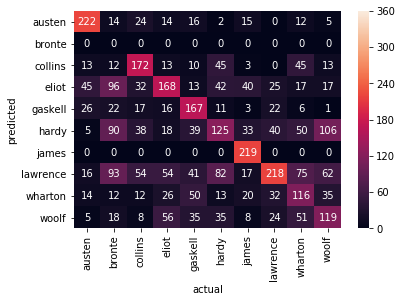

(0.42388888888888887,
 array(['lawrence', 'wharton', 'hardy', ..., 'james', 'lawrence', 'eliot'],
       dtype=object))

In [292]:
get_cluster_accuracy(spectral(tfidf_features_lsa, y_train, n_clusters=10, affinity='sigmoid')[0], y_train)

0.18406265526332657


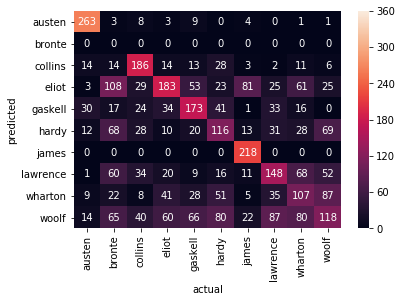

(0.42,
 array(['lawrence', 'gaskell', 'woolf', ..., 'james', 'lawrence', 'eliot'],
       dtype=object))

In [293]:
get_cluster_accuracy(kmeans(tfidf_features_lsa, y_train, n_clusters=10)[0], y_train)

### Spectral clustering with different affinities over different number of clusters

In [296]:
def spectral_accuracies_for_range(X_train, y_train, affinity, sample=1, cluster_range=(10, 20)):
    accuracies = dict()
    accuracy_stds = dict()
    adjusted_rands = dict()
    ari_stds = dict()
    for i in tqdm_notebook(range(cluster_range[0], cluster_range[1])):
        cluster_accuracies = []
        cluster_aris = []
        for _ in range(5):
            X_sample = pd.DataFrame(X_train).sample(frac=sample)
            sample_index = list(X_sample.index)
            y_sample = pd.DataFrame(y_train).loc[X_sample.index, :].values.flatten()
            X_sample = X_sample.values

            cluster_labels, ari = spectral(X_sample, y_sample, n_clusters=i, affinity=affinity, verbose=False)
            cluster_aris.append(ari)

            accuracy, _ = get_cluster_accuracy(cluster_labels, y_sample, plot=False)
            cluster_accuracies.append(accuracy)
            
        accuracies[i] = np.mean(cluster_accuracies)
        accuracy_stds[i] = np.std(cluster_accuracies)
        adjusted_rands[i] = np.mean(cluster_aris)
        ari_stds[i] = np.std(cluster_aris)
        
    return accuracies, accuracy_stds, adjusted_rands, ari_stds

In [297]:
(spectral_acc,
 spectral_acc_std,
 spectral_ari,
 spectral_ari_std) = spectral_accuracies_for_range(tfidf_features_lsa, y_train, affinity='sigmoid', sample=0.9, cluster_range=(10, 40))

In [298]:
print('n \t ari \t\t ari_std \t accuracy \t accuracy_std')
for i in range(10, 40):
    print('{} \t {:.4f} \t {:.4f} \t {:.4f} \t {:.4f}'.format(i, spectral_ari[i], spectral_ari_std[i], spectral_acc[i], spectral_acc_std[i]))

n 	 ari 		 ari_std 	 accuracy 	 accuracy_std
10 	 0.1627 	 0.0065 	 0.4156 	 0.0085
11 	 0.1709 	 0.0029 	 0.4308 	 0.0021
12 	 0.1593 	 0.0099 	 0.4099 	 0.0167
13 	 0.1501 	 0.0025 	 0.2993 	 0.1306
14 	 0.1582 	 0.0066 	 0.3852 	 0.0689
15 	 0.1476 	 0.0055 	 0.4006 	 0.0095
16 	 0.1528 	 0.0044 	 0.4228 	 0.0009
17 	 0.1644 	 0.0091 	 0.4346 	 0.0152
18 	 0.1653 	 0.0132 	 0.4419 	 0.0241
19 	 0.1542 	 0.0059 	 0.4288 	 0.0314
20 	 0.1508 	 0.0140 	 0.4007 	 0.0520
21 	 0.1566 	 0.0098 	 0.2930 	 0.1636
22 	 0.1567 	 0.0084 	 0.4303 	 0.0341
23 	 0.1526 	 0.0059 	 0.4502 	 0.0089
24 	 0.1381 	 0.0067 	 0.3660 	 0.1027
25 	 0.1337 	 0.0041 	 0.4315 	 0.0158
26 	 0.1390 	 0.0091 	 0.2437 	 0.1298
27 	 0.1336 	 0.0089 	 0.1633 	 0.0967
28 	 0.1190 	 0.0062 	 0.4338 	 0.0170
29 	 0.1195 	 0.0056 	 0.3081 	 0.1520
30 	 0.1158 	 0.0072 	 0.3693 	 0.1095
31 	 0.1120 	 0.0074 	 0.2997 	 0.1123
32 	 0.1109 	 0.0092 	 0.3928 	 0.1221
33 	 0.1103 	 0.0096 	 0.2795 	 0.1054
34 	 0.1052 	 0.007

In [299]:
(spectral_acc,
 spectral_acc_std,
 spectral_ari,
 spectral_ari_std) = spectral_accuracies_for_range(tfidf_features_lsa, y_train, affinity='linear', sample=0.9, cluster_range=(10, 40))

In [300]:
print('n \t ari \t\t ari_std \t accuracy \t accuracy_std')
for i in range(10, 40):
    print('{} \t {:.4f} \t {:.4f} \t {:.4f} \t {:.4f}'.format(i, spectral_ari[i], spectral_ari_std[i], spectral_acc[i], spectral_acc_std[i]))

n 	 ari 		 ari_std 	 accuracy 	 accuracy_std
10 	 0.1616 	 0.0091 	 0.4074 	 0.0105
11 	 0.1695 	 0.0043 	 0.4267 	 0.0052
12 	 0.1575 	 0.0052 	 0.4154 	 0.0057
13 	 0.1577 	 0.0083 	 0.4096 	 0.0178
14 	 0.1634 	 0.0066 	 0.4255 	 0.0099
15 	 0.1592 	 0.0050 	 0.3280 	 0.1142
16 	 0.1729 	 0.0113 	 0.4017 	 0.0818
17 	 0.1847 	 0.0127 	 0.4651 	 0.0112
18 	 0.1796 	 0.0152 	 0.3921 	 0.1208
19 	 0.1811 	 0.0091 	 0.4151 	 0.1006
20 	 0.1850 	 0.0069 	 0.4853 	 0.0043
21 	 0.1858 	 0.0091 	 0.3386 	 0.1459
22 	 0.1761 	 0.0060 	 0.3680 	 0.1464
23 	 0.1745 	 0.0078 	 0.4726 	 0.0310
24 	 0.1702 	 0.0079 	 0.4538 	 0.0858
25 	 0.1521 	 0.0050 	 0.4296 	 0.0456
26 	 0.1375 	 0.0118 	 0.2286 	 0.1649
27 	 0.1430 	 0.0073 	 0.3235 	 0.1586
28 	 0.1318 	 0.0082 	 0.2909 	 0.0868
29 	 0.1353 	 0.0040 	 0.3482 	 0.1311
30 	 0.1268 	 0.0067 	 0.4019 	 0.0712
31 	 0.1243 	 0.0043 	 0.4324 	 0.0595
32 	 0.1183 	 0.0118 	 0.3923 	 0.0876
33 	 0.1221 	 0.0051 	 0.3461 	 0.1228
34 	 0.1214 	 0.010

In [301]:
(spectral_acc,
 spectral_acc_std,
 spectral_ari,
 spectral_ari_std) = spectral_accuracies_for_range(tfidf_features_lsa, y_train, affinity='poly', sample=0.9, cluster_range=(10, 40))

In [302]:
print('n \t ari \t\t ari_std \t accuracy \t accuracy_std')
for i in range(10, 40):
    print('{} \t {:.4f} \t {:.4f} \t {:.4f} \t {:.4f}'.format(i, spectral_ari[i], spectral_ari_std[i], spectral_acc[i], spectral_acc_std[i]))

n 	 ari 		 ari_std 	 accuracy 	 accuracy_std
10 	 0.1620 	 0.0052 	 0.4173 	 0.0054
11 	 0.1592 	 0.0025 	 0.4221 	 0.0030
12 	 0.1553 	 0.0069 	 0.4217 	 0.0110
13 	 0.1554 	 0.0034 	 0.4189 	 0.0076
14 	 0.1583 	 0.0101 	 0.3356 	 0.1167
15 	 0.1511 	 0.0068 	 0.3706 	 0.1037
16 	 0.1575 	 0.0075 	 0.4089 	 0.0444
17 	 0.1595 	 0.0063 	 0.4268 	 0.0129
18 	 0.1622 	 0.0056 	 0.4406 	 0.0081
19 	 0.1676 	 0.0044 	 0.4088 	 0.0812
20 	 0.1538 	 0.0038 	 0.4165 	 0.0281
21 	 0.1604 	 0.0072 	 0.4336 	 0.0551
22 	 0.1576 	 0.0047 	 0.4551 	 0.0116
23 	 0.1449 	 0.0103 	 0.4144 	 0.0520
24 	 0.1433 	 0.0084 	 0.4447 	 0.0089
25 	 0.1347 	 0.0101 	 0.3821 	 0.1322
26 	 0.1253 	 0.0064 	 0.3899 	 0.0517
27 	 0.1257 	 0.0135 	 0.3599 	 0.1277
28 	 0.1246 	 0.0070 	 0.3398 	 0.1330
29 	 0.1220 	 0.0053 	 0.4067 	 0.0693
30 	 0.1125 	 0.0064 	 0.2781 	 0.0911
31 	 0.1089 	 0.0043 	 0.2991 	 0.1410
32 	 0.1120 	 0.0111 	 0.3856 	 0.1091
33 	 0.1082 	 0.0081 	 0.3844 	 0.1021
34 	 0.1039 	 0.008

In [303]:
(spectral_acc,
 spectral_acc_std,
 spectral_ari,
 spectral_ari_std) = spectral_accuracies_for_range(tfidf_features_lsa, y_train, affinity='rbf', sample=0.9, cluster_range=(10, 40))

In [304]:
print('n \t ari \t\t ari_std \t accuracy \t accuracy_std')
for i in range(10, 40):
    print('{} \t {:.4f} \t {:.4f} \t {:.4f} \t {:.4f}'.format(i, spectral_ari[i], spectral_ari_std[i], spectral_acc[i], spectral_acc_std[i]))

n 	 ari 		 ari_std 	 accuracy 	 accuracy_std
10 	 0.1497 	 0.0096 	 0.4030 	 0.0111
11 	 0.1587 	 0.0071 	 0.4207 	 0.0069
12 	 0.1509 	 0.0040 	 0.3573 	 0.1133
13 	 0.1512 	 0.0048 	 0.3723 	 0.0910
14 	 0.1537 	 0.0059 	 0.4234 	 0.0093
15 	 0.1535 	 0.0055 	 0.4203 	 0.0124
16 	 0.1666 	 0.0030 	 0.4262 	 0.0302
17 	 0.1609 	 0.0068 	 0.4391 	 0.0055
18 	 0.1636 	 0.0077 	 0.4051 	 0.0675
19 	 0.1543 	 0.0095 	 0.3625 	 0.1427
20 	 0.1609 	 0.0102 	 0.3664 	 0.1186
21 	 0.1564 	 0.0082 	 0.3240 	 0.1528
22 	 0.1509 	 0.0039 	 0.4096 	 0.0502
23 	 0.1497 	 0.0110 	 0.3260 	 0.1517
24 	 0.1446 	 0.0085 	 0.3307 	 0.1185
25 	 0.1367 	 0.0095 	 0.3619 	 0.1021
26 	 0.1254 	 0.0049 	 0.2824 	 0.1457
27 	 0.1236 	 0.0017 	 0.4004 	 0.0688
28 	 0.1143 	 0.0067 	 0.3033 	 0.1317
29 	 0.1138 	 0.0107 	 0.2945 	 0.1416
30 	 0.1155 	 0.0059 	 0.2965 	 0.0965
31 	 0.1092 	 0.0121 	 0.3359 	 0.1051
32 	 0.1053 	 0.0086 	 0.3657 	 0.1289
33 	 0.1060 	 0.0069 	 0.2581 	 0.1092
34 	 0.1063 	 0.004

### K-means clustering over different number of clusters

In [309]:
def kmeans_accuracies_for_range(X_train, y_train, sample=1, cluster_range=(10, 20)):
    accuracies = dict()
    accuracy_stds = dict()
    adjusted_rands = dict()
    ari_stds = dict()
    for i in tqdm_notebook(range(cluster_range[0], cluster_range[1])):
        cluster_accuracies = []
        cluster_aris = []
        for _ in range(5):
            X_sample = pd.DataFrame(X_train).sample(frac=sample)
            sample_index = list(X_sample.index)
            y_sample = pd.DataFrame(y_train).loc[X_sample.index, :].values.flatten()
            X_sample = X_sample.values

            cluster_labels, ari = kmeans(X_sample, y_sample, n_clusters=i, verbose=False)
            cluster_aris.append(ari)

            accuracy, _ = get_cluster_accuracy(cluster_labels, y_sample, plot=False)
            cluster_accuracies.append(accuracy)
            
        accuracies[i] = np.mean(cluster_accuracies)
        accuracy_stds[i] = np.std(cluster_accuracies)
        adjusted_rands[i] = np.mean(cluster_aris)
        ari_stds[i] = np.std(cluster_aris)
        
    return accuracies, accuracy_stds, adjusted_rands, ari_stds

In [310]:
(kmeans_acc,
 kmeans_acc_std,
 kmeans_ari,
 kmeans_ari_std) = kmeans_accuracies_for_range(tfidf_features_lsa, y_train, sample=0.9, cluster_range=(10, 40))

In [311]:
print('n \t ari \t\t ari_std \t accuracy \t accuracy_std')
for i in range(10, 40):
    print('{} \t {:.4f} \t {:.4f} \t {:.4f} \t {:.4f}'.format(i, kmeans_ari[i], kmeans_ari_std[i], kmeans_acc[i], kmeans_acc_std[i]))

n 	 ari 		 ari_std 	 accuracy 	 accuracy_std
10 	 0.1624 	 0.0145 	 0.3346 	 0.0933
11 	 0.1523 	 0.0153 	 0.3920 	 0.0163
12 	 0.1762 	 0.0179 	 0.4033 	 0.0625
13 	 0.1688 	 0.0114 	 0.3531 	 0.1018
14 	 0.1667 	 0.0125 	 0.4277 	 0.0161
15 	 0.1735 	 0.0335 	 0.3838 	 0.1388
16 	 0.1741 	 0.0206 	 0.3760 	 0.1292
17 	 0.1541 	 0.0190 	 0.4068 	 0.0577
18 	 0.1498 	 0.0232 	 0.4211 	 0.0329
19 	 0.1560 	 0.0062 	 0.4077 	 0.0322
20 	 0.1451 	 0.0067 	 0.3755 	 0.1184
21 	 0.1536 	 0.0266 	 0.4485 	 0.0417
22 	 0.1529 	 0.0167 	 0.4392 	 0.0276
23 	 0.1424 	 0.0155 	 0.3594 	 0.1389
24 	 0.1313 	 0.0151 	 0.3884 	 0.0994
25 	 0.1441 	 0.0167 	 0.3901 	 0.1164
26 	 0.1345 	 0.0071 	 0.4420 	 0.0259
27 	 0.1310 	 0.0103 	 0.2956 	 0.1069
28 	 0.1208 	 0.0106 	 0.4414 	 0.0250
29 	 0.1251 	 0.0132 	 0.4336 	 0.0453
30 	 0.1358 	 0.0062 	 0.4462 	 0.0585
31 	 0.1215 	 0.0044 	 0.4304 	 0.0602
32 	 0.1230 	 0.0124 	 0.3264 	 0.1587
33 	 0.1183 	 0.0105 	 0.4478 	 0.0253
34 	 0.1105 	 0.010

### Structural stability of clusters
The highest adjusted Rand score with the lowest standard deviation was obtained by spectral clustering with affinity='cosine' and n_clusters=20. I will resample the training data at 66% for 152 times to see how stable the clusters are, using the figure of merit proposed in ["Resampling Method For Unsupervised Estimation Of Cluster Validity"](https://arxiv.org/abs/physics/0005046v1) by (Levine & Domany, 2000) to quantify structural stability.

In [374]:
def create_connectivity_matrix(cluster_labels, index, size):
    connectivity_matrix = np.zeros((size, size))
    missing_idxs = np.setdiff1d(range(size), index)
    
    history = []
    for missing_idx in missing_idxs:
        for prior_idx in history:
            connectivity_matrix[missing_idx, prior_idx] = -1
            connectivity_matrix[prior_idx, missing_idx] = -1
        history.append(missing_idx)
        
    for label in np.unique(cluster_labels):
        node_idxs = np.nonzero(cluster_labels==label)[0]
        history = []
        for node_idx in node_idxs:
            for missing_idx in missing_idxs:
                connectivity_matrix[missing_idx, index[node_idx]] = -1
                connectivity_matrix[index[node_idx], missing_idx] = -1
            for prior_idx in history:
                connectivity_matrix[index[node_idx], prior_idx] = 1
                connectivity_matrix[prior_idx, index[node_idx]] = 1
            history.append(index[node_idx])
    return connectivity_matrix

# figure of merit for estimating cluster validity according to the paper
# "Resampling Method For Unsupervised EStimation of Cluster Validity" by
# Levine and Domany, 2018
def figure_of_merit(original, resample):
    # pairs that could have been connected given the resampled points
    resample_mask = ma.masked_values(resample, -1).mask
    original_masked = ma.masked_array(original, mask=resample_mask)
    
    # pairs that were connected in the original
    original_mask = ma.masked_values(original_masked, 0).mask
    resample_masked = ma.masked_array(resample, mask=original_mask)
    
    # number of pairs that are still connected in the resample
    surviving_pairs = np.sum(resample_masked)/2
    surviving_pairs if surviving_pairs != ma.core.MaskedConstant else 0
    
    # number of pairs that were connected in the original and could have been connected
    possible_pairs = np.sum(original_masked)/2
    possible_pairs if possible_pairs != ma.core.MaskedConstant else 0
    
    # figure of merit
    return surviving_pairs/possible_pairs if possible_pairs > 0 else 1

In [378]:
def spectral_accuracies_for_nclusters(X_train, y_train, affinity, n_trials, orig_con_mat, sample=1, n_clusters=10):
    predictions = pd.DataFrame(index=range(len(X_train)))
    accuracies = dict()
    adjusted_rands = dict()
    figure_of_merits = []
    for i in tqdm_notebook(range(n_trials)):
        X_sample = pd.DataFrame(X_train).sample(frac=sample)
        sample_index = list(X_sample.index)
        y_sample = pd.DataFrame(y_train).loc[X_sample.index, :].values.flatten()
        X_sample = X_sample.values
        
        cluster_labels, ari = spectral(X_sample, y_sample, n_clusters=n_clusters, affinity=affinity, verbose=False)
        adjusted_rands[i] = ari
        con_mat = create_connectivity_matrix(cluster_labels, sample_index, len(y_train))
        figure_of_merits.append(figure_of_merit(orig_con_mat, con_mat))
        
        accuracy, pred = get_cluster_accuracy(cluster_labels, y_sample, plot=False)
        predictions[predictions.shape[1]] = pd.Series(pred, index=sample_index)
        accuracies[i] = accuracy
        
    return accuracies, adjusted_rands, predictions, figure_of_merits

In [386]:
spectral_cluster_labels_20, _ = spectral(tfidf_features_lsa, y_train, n_clusters=20, affinity='linear')
spectral_orig_con_mat_20 = create_connectivity_matrix(spectral_cluster_labels_20, range(len(y_train)), len(y_train))

0.19344448430807185


In [387]:
(spectral_accuracies_20,
 spectral_ari_20,
 spectral_predictions_20,
 spectral_foms_20) = spectral_accuracies_for_nclusters(tfidf_features_lsa,
                                                       y_train,
                                                       affinity='linear',
                                                       n_trials=152,
                                                       orig_con_mat=spectral_orig_con_mat_20,
                                                       sample=0.66,
                                                       n_clusters=20)

In [388]:
print(np.mean(list(spectral_ari_20.values())))
print(np.std(list(spectral_ari_20.values())))
print()
print(np.mean(list(spectral_accuracies_20.values())))
print(np.std(list(spectral_accuracies_20.values())))
print()
print(np.mean(spectral_foms_20))
print(np.std(spectral_foms_20))

0.16570723160409917
0.014738385479309045

0.3822656388445862
0.12075082187384409

0.43792795987751443
0.03923207036732916


### Estimating accuracy and prediction stability
We did 100 resamples of the training data, so we can calculate how often each point was predicted to be a certain author. 

In [389]:
spectral_modes = spectral_predictions_20.apply(lambda x: x.value_counts()[0], axis=1)
spectral_labels = spectral_predictions_20.apply(lambda x: x.value_counts().index[0], axis=1)
spectral_nans = spectral_predictions_20.apply(lambda x: x.isna().sum(), axis=1)
spectral_stabilities = spectral_modes / (152 - spectral_nans)

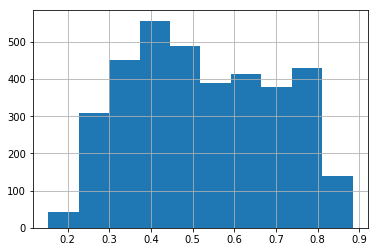

In [393]:
spectral_stabilities.hist()
plt.show()

In [394]:
spectral_20_train_results = pd.DataFrame({'stability': spectral_stabilities, 'pred':spectral_labels, 'label': y_train})
spectral_20_train_results.head()

,stability,pred,label
0,0.562500,lawrence,lawrence
1,0.457944,gaskell,gaskell
2,0.485149,wharton,collins
3,0.403846,collins,collins
4,0.476190,lawrence,bronte


In [395]:
# stability for authors that are predicted correctly
spectral_20_train_results.loc[spectral_20_train_results['pred'] == spectral_20_train_results['label'], ['stability', 'label']].sort_values(by='stability', ascending=False).groupby('label').median()

,stability
label,
austen,0.735768
bronte,0.444524
collins,0.646149
eliot,0.612245
gaskell,0.586671
hardy,0.482857
james,0.797980
lawrence,0.584158
wharton,0.580125


In [396]:
# stability for authors not predicted correctly
spectral_20_train_results.loc[spectral_20_train_results['pred'] != spectral_20_train_results['label'], ['stability', 'label']].sort_values(by='stability', ascending=False).groupby('label').median()

,stability
label,
austen,0.455428
bronte,0.436170
collins,0.412371
eliot,0.407587
gaskell,0.456311
hardy,0.415842
james,0.432692
lawrence,0.408249
wharton,0.429286


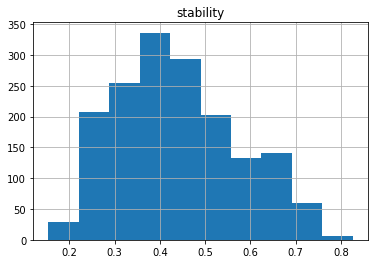

In [397]:
# stability for authors not predicted correctly
spectral_20_train_results.loc[spectral_20_train_results['pred'] != spectral_20_train_results['label'], ['stability']].hist()
plt.show()

In [398]:
# accuracy of clustering
spectral_20_train_results.loc[spectral_20_train_results['pred'] == spectral_20_train_results['label'], :].shape[0] / len(X_train)

0.5388888888888889

### Stability of clusters found in holdout set

In [399]:
holdout_cluster_labels_20, _ = spectral(holdout_tfidf_features_lsa, y_test, n_clusters=20, affinity='linear')
holdout_orig_con_mat_20 = create_connectivity_matrix(holdout_cluster_labels_20, range(len(y_test)), len(y_test))

0.13776973371490078


In [400]:
(holdout_accuracies_20,
 holdout_ari_20,
 holdout_predictions_20,
 holdout_foms_20) = spectral_accuracies_for_nclusters(holdout_tfidf_features_lsa,
                                                       y_test,
                                                       affinity='linear',
                                                       n_trials=152,
                                                       orig_con_mat=holdout_orig_con_mat_20,
                                                       sample=0.66,
                                                       n_clusters=20)

In [430]:
def print_cluster_stats(aris, accuracies, foms):
    print('Mean adjusted Rand index: {}'.format(np.mean(list(aris.values()))))
    print('Std adjusted Rand index: {}'.format(np.std(list(aris.values()))))
    print()
    print('Mean accuracy: {}'.format(np.mean(list(accuracies.values()))))
    print('Std accuracy: {}'.format(np.std(list(accuracies.values()))))
    print()
    print('Mean figure of merit: {}'.format(np.mean(foms)))
    print('Std figure of merit: {}'.format(np.std(foms)))

In [401]:
print(np.mean(list(holdout_ari_20.values())))
print(np.std(list(holdout_ari_20.values())))
print()
print(np.mean(list(holdout_accuracies_20.values())))
print(np.std(list(holdout_accuracies_20.values())))
print()
print(np.mean(holdout_foms_20))
print(np.std(holdout_foms_20))

0.13249515998133607
0.016279448292064982

0.26646398192450826
0.12449258395044108

0.36635350238588454
0.031725212933314755


In [411]:
spectral_modes = holdout_predictions_20.apply(lambda x: x.value_counts()[0], axis=1)
spectral_labels = holdout_predictions_20.apply(lambda x: x.value_counts().index[0], axis=1)
spectral_nans = holdout_predictions_20.apply(lambda x: x.isna().sum(), axis=1)
spectral_stabilities = spectral_modes / (152 - spectral_nans)

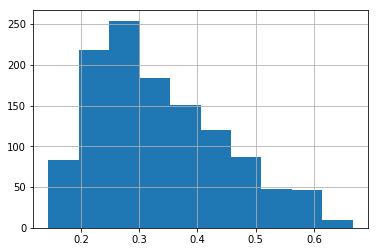

In [412]:
spectral_stabilities.hist()
plt.show()

In [414]:
holdout_20_train_results = pd.DataFrame({'stability': spectral_stabilities, 'pred':spectral_labels, 'label': y_test})
holdout_20_train_results.head()

,stability,pred,label
0,0.291262,bronte,bronte
1,0.215054,eliot,lawrence
2,0.526882,james,james
3,0.610526,james,james
4,0.434343,austen,austen


In [415]:
# stability for authors that are predicted correctly
holdout_20_train_results.loc[holdout_20_train_results['pred'] == holdout_20_train_results['label'], ['stability', 'label']].sort_values(by='stability', ascending=False).groupby('label').median()

,stability
label,
austen,0.425070
bronte,0.323529
collins,0.331502
eliot,0.360463
gaskell,0.347643
hardy,0.303030
james,0.584158
lawrence,0.343000
wharton,0.290000


In [416]:
# stability for authors not predicted correctly
holdout_20_train_results.loc[holdout_20_train_results['pred'] != holdout_20_train_results['label'], ['stability', 'label']].sort_values(by='stability', ascending=False).groupby('label').median()

,stability
label,
austen,0.298515
bronte,0.283519
collins,0.277778
eliot,0.257732
gaskell,0.252525
hardy,0.265477
james,0.267327
lawrence,0.226804
wharton,0.283066


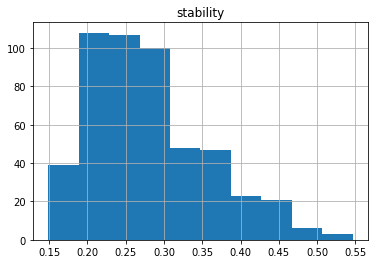

In [417]:
# stability for authors not predicted correctly
holdout_20_train_results.loc[holdout_20_train_results['pred'] != holdout_20_train_results['label'], ['stability']].hist()
plt.show()

In [418]:
# accuracy of clustering
holdout_20_train_results.loc[holdout_20_train_results['pred'] == holdout_20_train_results['label'], :].shape[0] / len(X_train)

0.1938888888888889

# Test on hold out set
To test the stability of these clusters on the holdout set, we can resample the data again, but with the holdout set included. I've chosen to include all the data in the holdout set and include a random subset of 66% the training data for each resampling to match the amount used in calculating the figure of merit.

In [443]:
def spectral_accuracies_for_holdout(X_train, y_train, X_test, y_test, affinity,
                                    n_trials, orig_con_mat, sample=1, n_clusters=10, fom='train'):
    predictions = pd.DataFrame(index=range(len(X_train) + len(X_test)))
    accuracies = dict()
    adjusted_rands = dict()
    figure_of_merits = []
    for i in tqdm_notebook(range(n_trials)):
        X_sample = pd.DataFrame(X_train).sample(frac=sample)
        sample_index = list(X_sample.index)
        y_sample = pd.DataFrame(y_train).loc[X_sample.index, :].values.flatten()
        X_sample = X_sample.values

        # add the index for holdout data
        sample_index += list(range(len(X_train), len(X_train) + len(X_test)))

        # append the holdout data
        X_sample = np.concatenate((X_sample, X_test), axis=0)
        y_sample = np.concatenate((y_sample, y_test), axis=0)

        cluster_labels, ari = spectral(X_sample, y_sample, n_clusters=n_clusters, affinity=affinity, verbose=False)
        adjusted_rands[i] = ari
        if fom == 'train':
            con_mat = create_connectivity_matrix(cluster_labels[:len(y_sample)-len(y_test)],
                                                 sample_index[:len(y_sample)-len(y_test)],
                                                 len(y_train))
        elif fom == 'test':
            con_mat = create_connectivity_matrix(cluster_labels[len(y_sample)-len(y_test):],
                                                 range(len(y_test)),
                                                 len(y_test))
        figure_of_merits.append(figure_of_merit(orig_con_mat, con_mat))

        accuracy, pred = get_cluster_accuracy(cluster_labels, y_sample, plot=False)
        predictions[predictions.shape[1]] = pd.Series(pred, index=sample_index)
        accuracies[i] = accuracy
        
    return accuracies, adjusted_rands, predictions, figure_of_merits

## Structural stability for holdout observations

In [451]:
spectral_train_sample = 0.66

(spectral_accuracies_holdout,
 spectral_ari_holdout,
 spectral_predictions_holdout,
 spectral_foms) = spectral_accuracies_for_holdout(tfidf_features_lsa,
                                                  y_train,
                                                  holdout_tfidf_features_lsa,
                                                  y_test,
                                                  affinity='linear',
                                                  n_trials=100,
                                                  orig_con_mat=holdout_orig_con_mat_20,
                                                  sample=spectral_train_sample,
                                                  n_clusters=20,
                                                  fom='test')

In [453]:
# sample only 100 times because all the holdset observations are included in each resample
assert spectral_predictions_holdout.shape == (len(X_train) + len(X_test), 100)

In [454]:
print_cluster_stats(spectral_ari_holdout, spectral_accuracies_holdout, spectral_foms)

Mean adjusted Rand index: 0.1719039617531156
Std adjusted Rand index: 0.010879424587396894

Mean accuracy: 0.42341442953020125
Std accuracy: 0.09907690618290434

Mean figure of merit: 0.4151271244800705
Std figure of merit: 0.023163768678206565


## Structural stability for training observations

In [455]:
spectral_accuracies_trials = 152

(spectral_accuracies_holdout,
 spectral_ari_holdout,
 spectral_predictions_holdout,
 spectral_foms) = spectral_accuracies_for_holdout(tfidf_features_lsa,
                                                  y_train,
                                                  holdout_tfidf_features_lsa,
                                                  y_test,
                                                  affinity='linear',
                                                  n_trials=spectral_accuracies_trials,
                                                  orig_con_mat=spectral_orig_con_mat_20,
                                                  sample=spectral_train_sample,
                                                  n_clusters=20,
                                                  fom='train')

In [456]:
assert spectral_predictions_holdout.shape == (len(X_train) + len(X_test), spectral_accuracies_trials)

In [457]:
print_cluster_stats(spectral_ari_holdout, spectral_accuracies_holdout, spectral_foms)

Mean adjusted Rand index: 0.1697488560916345
Std adjusted Rand index: 0.011229557931756864

Mean accuracy: 0.4161349788060756
Std accuracy: 0.099505925965987

Mean figure of merit: 0.45776482037019595
Std figure of merit: 0.029161574247002803


### Training observations accuracy and prediction stability

In [458]:
holdout_spectral_predictions_20 = spectral_predictions_holdout.head(len(X_train))

holdout_spectral_modes = holdout_spectral_predictions_20.apply(lambda x: x.value_counts()[0], axis=1)

holdout_spectral_labels = holdout_spectral_predictions_20.apply(lambda x: x.value_counts().index[0], axis=1)

holdout_spectral_nans = holdout_spectral_predictions_20.apply(lambda x: x.isna().sum(), axis=1)

holdout_spectral_stabilities = holdout_spectral_modes / (spectral_accuracies_trials - holdout_spectral_nans)

In [459]:
spectral_20_train_results['holdout_stability'] = holdout_spectral_stabilities
spectral_20_train_results['holdout_pred'] = holdout_spectral_labels

In [460]:
# % points in the training data that were classified the same as without the holdout data
spectral_20_train_results.loc[spectral_20_train_results['pred'] == spectral_20_train_results['holdout_pred'], :].shape[0]/len(X_train)

0.7763888888888889

In [461]:
# accuracy of clustering on training data
spectral_20_train_results.loc[spectral_20_train_results['holdout_pred'] == spectral_20_train_results['label'], :].shape[0] / len(X_train)

0.5205555555555555

In [488]:
# stability for authors that are predicted correctly
spectral_20_train_results.loc[spectral_20_train_results['holdout_pred'] == spectral_20_train_results['label'], ['stability', 'label']].sort_values(by='stability', ascending=False).groupby('label').median()

,stability
label,
austen,0.739529
bronte,0.442751
collins,0.665017
eliot,0.636364
gaskell,0.557708
hardy,0.490181
james,0.797980
lawrence,0.592820
wharton,0.647059


In [489]:
# stability for authors not predicted correctly
spectral_20_train_results.loc[spectral_20_train_results['holdout_pred'] != spectral_20_train_results['label'], ['stability', 'label']].sort_values(by='stability', ascending=False).groupby('label').median()

,stability
label,
austen,0.483095
bronte,0.436170
collins,0.413043
eliot,0.408383
gaskell,0.462963
hardy,0.413462
james,0.425530
lawrence,0.413462
wharton,0.442478


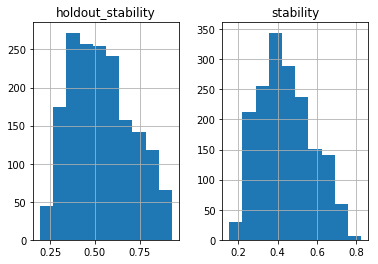

In [462]:
spectral_20_train_results.loc[spectral_20_train_results['holdout_pred'] != spectral_20_train_results['label'], ['holdout_stability', 'stability']].hist()
plt.show()

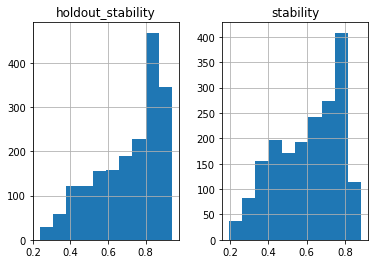

In [463]:
spectral_20_train_results.loc[spectral_20_train_results['holdout_pred'] == spectral_20_train_results['label'], ['holdout_stability', 'stability']].hist()
plt.show()

In [464]:
spectral_20_train_results['match'] = (spectral_20_train_results['holdout_pred'] == spectral_20_train_results['pred'])

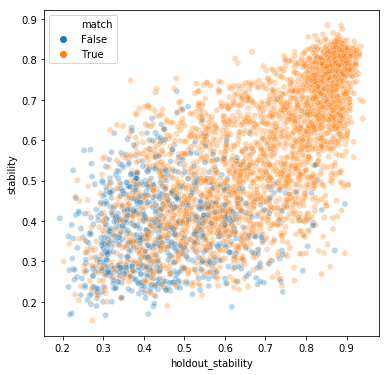

In [465]:
sns.scatterplot(x='holdout_stability', y='stability', data=spectral_20_train_results, alpha=0.3, hue='match')
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.show()

Clustering on the holdout set plus random subsets of 66% of the training set results in about the same accuracy as clustering only on the training set. 78% of the training data were predicted to be the same author as before. Points with high stability were more likely to be accurately predicted than points with low stability.

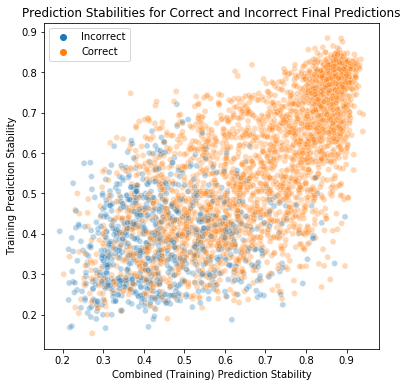

In [591]:
def plot_for_report():
    sns.scatterplot(x='holdout_stability', y='stability', data=spectral_20_train_results, alpha=0.3, hue='match')
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[1:], ['Incorrect', 'Correct'])
    
    ax.set_ylabel('Training Prediction Stability')
    ax.set_xlabel('Combined (Training) Prediction Stability')
    ax.set_title('Prediction Stabilities for Correct and Incorrect Final Predictions')
    
    fig = plt.gcf()
    fig.set_size_inches(6,6)
    plt.savefig('love-stories-part2-prediction-stabilities.png')

plot_for_report()

### Holdout observations accuracy and prediction stability

In [466]:
holdout_spectral_predictions = spectral_predictions_holdout.tail(len(X_test))

holdout_spectral_modes = holdout_spectral_predictions.apply(lambda x: x.value_counts()[0], axis=1)

holdout_spectral_labels = holdout_spectral_predictions.apply(lambda x: x.value_counts().index[0], axis=1)

holdout_spectral_nans = holdout_spectral_predictions.apply(lambda x: x.isna().sum(), axis=1)

holdout_spectral_stabilities = holdout_spectral_modes / (spectral_accuracies_trials - holdout_spectral_nans)

In [467]:
holdout_test_results = pd.DataFrame({'holdout_stability': holdout_spectral_stabilities,
                                     'holdout_pred': holdout_spectral_labels,
                                     'label': y_test})
holdout_test_results.head()

,holdout_stability,holdout_pred,label
3600,0.828947,bronte,bronte
3601,0.611842,bronte,lawrence
3602,0.888158,james,james
3603,0.888158,james,james
3604,0.657895,austen,austen


In [468]:
# accuracy of clustering on holdout data
holdout_test_results.loc[holdout_test_results['holdout_pred'] == holdout_test_results['label'], :].shape[0] / len(X_test)

0.5016666666666667

The accuracy of the predictions for the holdout observations is about the same as for the training observations. 

In [492]:
# stability for authors that are predicted correctly
holdout_test_results.loc[holdout_test_results['holdout_pred'] == holdout_test_results['label'], ['holdout_stability', 'label']].sort_values(by='holdout_stability', ascending=False).groupby('label').median()

,holdout_stability
label,
austen,0.842105
bronte,0.605263
collins,0.848684
eliot,0.753289
gaskell,0.618421
hardy,0.631579
james,0.888158
lawrence,0.638158
wharton,0.828947


In [493]:
# stability for authors not predicted correctly
holdout_test_results.loc[holdout_test_results['holdout_pred'] != holdout_test_results['label'], ['holdout_stability', 'label']].sort_values(by='holdout_stability', ascending=False).groupby('label').median()

,holdout_stability
label,
austen,0.509868
bronte,0.526316
collins,0.500000
eliot,0.532895
gaskell,0.559211
hardy,0.519737
james,0.529605
lawrence,0.447368
wharton,0.509868


In [497]:
testit = spectral_20_train_results.loc[spectral_20_train_results['pred'] == spectral_20_train_results['label'], ['stability', 'label']].sort_values(by='stability', ascending=False).groupby('label').median()

In [498]:
testit['incorrect'] = spectral_20_train_results.loc[spectral_20_train_results['pred'] != spectral_20_train_results['label'], ['stability', 'label']].sort_values(by='stability', ascending=False).groupby('label').median()

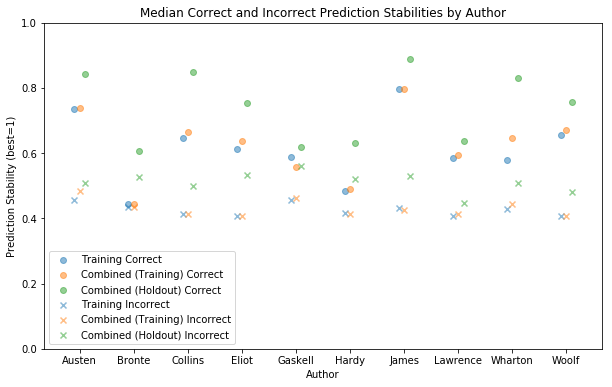

In [576]:
def plot_for_report():
    author_stabilities = pd.DataFrame(index=np.unique(y_test))
    
    author_stabilities['training_correct'] = spectral_20_train_results.loc[spectral_20_train_results['pred'] == spectral_20_train_results['label'], ['stability', 'label']].sort_values(by='stability', ascending=False).groupby('label').median()
    author_stabilities['training_incorrect'] = spectral_20_train_results.loc[spectral_20_train_results['pred'] != spectral_20_train_results['label'], ['stability', 'label']].sort_values(by='stability', ascending=False).groupby('label').median()

    author_stabilities['combined_training_correct'] = spectral_20_train_results.loc[spectral_20_train_results['holdout_pred'] == spectral_20_train_results['label'], ['stability', 'label']].sort_values(by='stability', ascending=False).groupby('label').median()
    author_stabilities['combined_training_incorrect'] = spectral_20_train_results.loc[spectral_20_train_results['holdout_pred'] != spectral_20_train_results['label'], ['stability', 'label']].sort_values(by='stability', ascending=False).groupby('label').median()

    author_stabilities['combined_holdout_correct'] = holdout_test_results.loc[holdout_test_results['holdout_pred'] == holdout_test_results['label'], ['holdout_stability', 'label']].sort_values(by='holdout_stability', ascending=False).groupby('label').median()
    author_stabilities['combined_holdout_incorrect'] = holdout_test_results.loc[holdout_test_results['holdout_pred'] != holdout_test_results['label'], ['holdout_stability', 'label']].sort_values(by='holdout_stability', ascending=False).groupby('label').median()

    fig, axes = plt.subplots(1, 1)

    ax = axes
    offset = -0.1
    for idx, column in enumerate(['training_correct', 'combined_training_correct', 'combined_holdout_correct']):
        ax.scatter(x=np.arange(10)+offset,
                   y=author_stabilities[column],
                   alpha=0.5,
                   color=sns.color_palette()[idx])
        offset += 0.1
        
    offset = -0.1
    for idx, column in enumerate(['training_incorrect', 'combined_training_incorrect', 'combined_holdout_incorrect']):
        ax.scatter(x=np.arange(10)+offset,
                   y=author_stabilities[column],
                   alpha=0.5,
                   marker='x',
                   color=sns.color_palette()[idx])
        offset += 0.1
        
    ax.set_title('Median Correct and Incorrect Prediction Stabilities by Author')
    ax.set_ylim((0, 1))
    ax.set_ylabel('Prediction Stability (best=1)')
    ax.set_xticks(range(0, 10))
    ax.set_xlabel('Author')
    ax.set_xticklabels([author.title() for author in author_stabilities.index])
    
    ax.legend(['Training Correct', 'Combined (Training) Correct', 'Combined (Holdout) Correct',
               'Training Incorrect', 'Combined (Training) Incorrect', 'Combined (Holdout) Incorrect'])

    fig = plt.gcf()
    fig.set_size_inches(10, 6)
    plt.savefig('love-stories-part2-author-stabilities.png')

plot_for_report()